In [2]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/dmeyer/bindingQTL_share/rb-209")
results_dir.mkdir(parents=True, exist_ok=True)

In [25]:
!ls /home/dmeyer/projects/bqtls/tdp43/allelic

tdp43_input_allelic.out		   tdp43_ip_allelic.out
tdp43_input_annotated_allelic.out  tdp43_ip_annotated_allelic.out
tdp43_input_waspfiltered.bam	   tdp43_ip_waspfiltered.bam
tdp43_input_waspfiltered_sort.bam  tdp43_ip_waspfiltered_sort.bam


 Load input RNA allelic counts.

In [4]:
basedir = "/gpfs/commons/home/dmeyer/bindingQTL_share/rb-209/allelic/"
input_files = [ "/gpfs/commons/home/dmeyer/bindingQTL_share/rb-209/allelic/rb-209_input_allelic.out" ]
#input_files = [ "/home/dmeyer/projects/bqtls/tdp43/tdp43_filtered_input.txt" ]
#input_files = [ basedir + "tdp43_input_allelic.out"]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

IP_files = [ basedir + "rb-209_ip_allelic.out" ]

IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]
IP_counts[0]

contig   position    variantID refAllele altAllele  refCount  altCount  \
0        chr1     135163  rs374499151         C         T       142         0   
1        chr1     135203  rs147502335         G         A       112         0   
2        chr1     138593  rs375595668         G         T        40         0   
3        chr1     629885  rs193303036         A         G        12         0   
4        chr1     629906    rs1578391         C         T         0        12   
...       ...        ...          ...       ...       ...       ...       ...   
460818   chrX  155239456       rs3599         T         C       126         0   
460819   chrX  155239765  rs143206182         T         C        64         0   
460820   chrX  155259147    rs3105275         A         G         0        16   
460821   chrX  155260521  rs147213132         C         A        13         0   
460822   chrX  155559835    rs5940513         A         G         0        12   

        totalCount  
0              142  
1              112  
2               40  
3               12  
4               12  
...            ...  
460818         126  
460819          64  
460820          16  
460821          13  
460822          12  

[460823 rows x 8 columns]

In [3]:
input_counts[0]

chrom  position   variantID refAllele altAllele  refCount  altCount  \
0       chr1   1486151    rs819976         C         A        19        17   
1       chr1   1490320    rs819980         T         C        20        33   
2       chr1   1496122      rs8241         G         A        27        23   
3       chr1   1665061  rs72634819         C         T        24        14   
4       chr1   2231568  rs10910031         A         G        15        15   
...      ...       ...         ...       ...       ...       ...       ...   
10619  chr22  50280822  rs11547734         A         G        38        36   
10620  chr22  50282193  rs11547728         C         T        17        22   
10621  chr22  50283705  rs11547731         T         C        27        20   
10622  chr22  50287124  rs28513473         T         C        40        32   
10623  chr22  50439767  rs13057311         G         A        20        13   

       totalCount  
0              36  
1              53  
2              50  
3              38  
4              30  
...           ...  
10619          74  
10620          39  
10621          47  
10622          72  
10623          33  

[10624 rows x 8 columns]

Observed genotype data (after running StrandScript)

## Load imputed genotypes

In [18]:
!ls /home/dmeyer/projects/bqtls/

allhet_fixedH.1kg.vcf.gz	     old_secondround_bqtls
allhet_fixedH.1kg.vcf.gz.tbi	     sanger.feather
ipsc_imputation_het_hg38.vcf.gz      SecondRound_bQTLs
ipsc_imputation_het_hg38.vcf.gz.tbi  tdp43


In [1]:
#geno = io_utils.loadGenotypes(
#    '/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.vcf.gz',
#    maxlines = None, 
#    posterior = False,
#    print_every = 1e5,
#    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
#geno.reset_index().to_feather('/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.feather')

In [4]:
#sanger_feather = Path("/home/dmeyer/projects/bqtls/ipsc_imputation_het_hg38.feather")
sanger_feather = Path("/home/dmeyer/projects/bqtls/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [5]:
#sanger=sanger[list(sanger.columns[[1,0]])+list(sanger.columns[2:])]
sanger = sanger.rename(columns = {"variantID": "SNP"})

In [6]:
#[f"{sanger.contig[i]}:{sanger.position[i]}:{sanger.refAllele[i]}:{sanger.altAllele[i]}" for i in range(sanger.shape[0])]

In [6]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

## Look at phase within genes

In [7]:
import gc
gc.collect()

0

In [8]:
sample_ind = [ g for g in cols if "CW" in g ][0]
sample_ind = [ g for g in cols if "CW70142" in g ][0]

In [9]:
sample_ind

'CW70142-1-1194512527_CW70142-1-1194512527'

In [10]:
cols

['contig',
 'position',
 'SNP',
 'refAllele',
 'altAllele',
 'CW30274-1-1194512543_CW30274-1-1194512543',
 'CW30454-1-1194512472_CW30454-1-1194512472',
 'CW30421-1-1194512512_CW30421-1-1194512512',
 'CW70372-1-1194512488_CW70372-1-1194512488',
 'CW40201-1-1194512480_CW40201-1-1194512480',
 'CW30525-1-1194512464_CW30525-1-1194512464',
 'CW30190-1-1194512504_CW30190-1-1194512504',
 'CW30108-1-1194512496_CW30108-1-1194512496',
 'CW30154-1-1194512551_CW30154-1-1194512551',
 'CW70179-1-1194512535_CW70179-1-1194512535',
 'CW70142-1-1194512527_CW70142-1-1194512527']

In [11]:
import vcf
import gzip
#vcf_reader = vcf.Reader(filename = '/home/dmeyer/projects/bqtls/sanger.vcf.gz')

#gen = [next(vcf_reader) for _ in range(10000)]
#gen = vcf_reader

import pickle
with open("/home/dmeyer/projects/bqtls/sanger.v.pickle", "rb") as f:
    v = pickle.load(f)

#v = [ (record.CHROM, 
# record.POS, 
# record.ID, 
# record.REF, 
# record.ALT[0].sequence, 
# record.genotype(sample_ind).data.GT, 
# record.genotype(sample_ind).data.ADS[0],
# record.genotype(sample_ind).data.ADS[1]) 
#      for record in gen if (record.genotype(sample_ind).data.GT != "0|0") ]

chroms, pos, ids, ref, alt, gt, ads1, ads2 = zip(*v)
#phased = pd.DataFrame({
#    "contig" : chroms,
#    "position" : pos,
#    "SNP" : ids, 
#    "refAllele" : ref, 
#    "altAllele" : alt, 
#    "GT" : gt, 
#    "dosage1" : ads1, # dosage for haplotype 1
#    "dosage2" : ads2 # dosage for haplotype 2
#})
#
#phased.to_csv(
#    '/home/dmeyer/projects/bqtls/CW70142.phased.csv', 
#    index = False, 
#    sep = "\t")

In [103]:
#import pickle
#with open("/home/dmeyer/projects/bqtls/sanger.v.pickle", "wb") as f:
#    pickle.dump(v, f)

In [12]:
phased = pd.read_table('/home/dmeyer/projects/bqtls/CW70142.phased.csv', sep="\t", index_col=None)

In [13]:
phased.SNP = phased.SNP.astype('str')
phased.contig = phased.contig.astype('str')
phased.contig = "chr" + phased.contig
phased_clean = phased[phased.SNP != "None"]

In [14]:
dat = input_counts[0]
dat = dat.rename(columns={ "chrom":"contig" })
dat_IP = IP_counts[0]

dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = phased_clean.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount


In [15]:
imp_merged

contig  position_hg19   variantID refAllele altAllele   GT  dosage1  \
0      chr10         459940   rs4881274         G         A  0|1      0.0   
1      chr10        1034412  rs12772979         C         T  0|1      0.0   
2      chr10        1046712   rs2306409         G         A  1|0      1.0   
3      chr10        1090469  rs66797613         C         T  0|1      0.0   
4      chr10        3150898  rs11251721         C         T  1|0      1.0   
...      ...            ...         ...       ...       ...  ...      ...   
10616   chr9      139617662     rs11849         T         C  1|0      1.0   
10617   chr9      139618283      rs6873         A         G  1|0      1.0   
10618   chr9      139619366      rs6866         C         G  1|0      1.0   
10619   chr9      140084376  rs11556580         G         A  1|0      1.0   
10620   chr9      140084485   rs3087779         G         A  1|0      1.0   

       dosage2   position  refCount  altCount  totalCount  input_ratio  
0         1.00     414000        20        18          38     0.473684  
1         0.95     988472        13        24          37     0.648649  
2         0.00    1000772        51        74         125     0.592000  
3         1.00    1044529        21        13          34     0.382353  
4         0.00    3108706        53        49         102     0.480392  
...        ...        ...       ...       ...         ...          ...  
10616     0.00  136723210        25        22          47     0.468085  
10617     0.00  136723831        34        31          65     0.476923  
10618     0.00  136724914        33        32          65     0.492308  
10619     0.05  137189924        41        48          89     0.539326  
10620     0.05  137190033        31        31          62     0.500000  

[10621 rows x 13 columns]

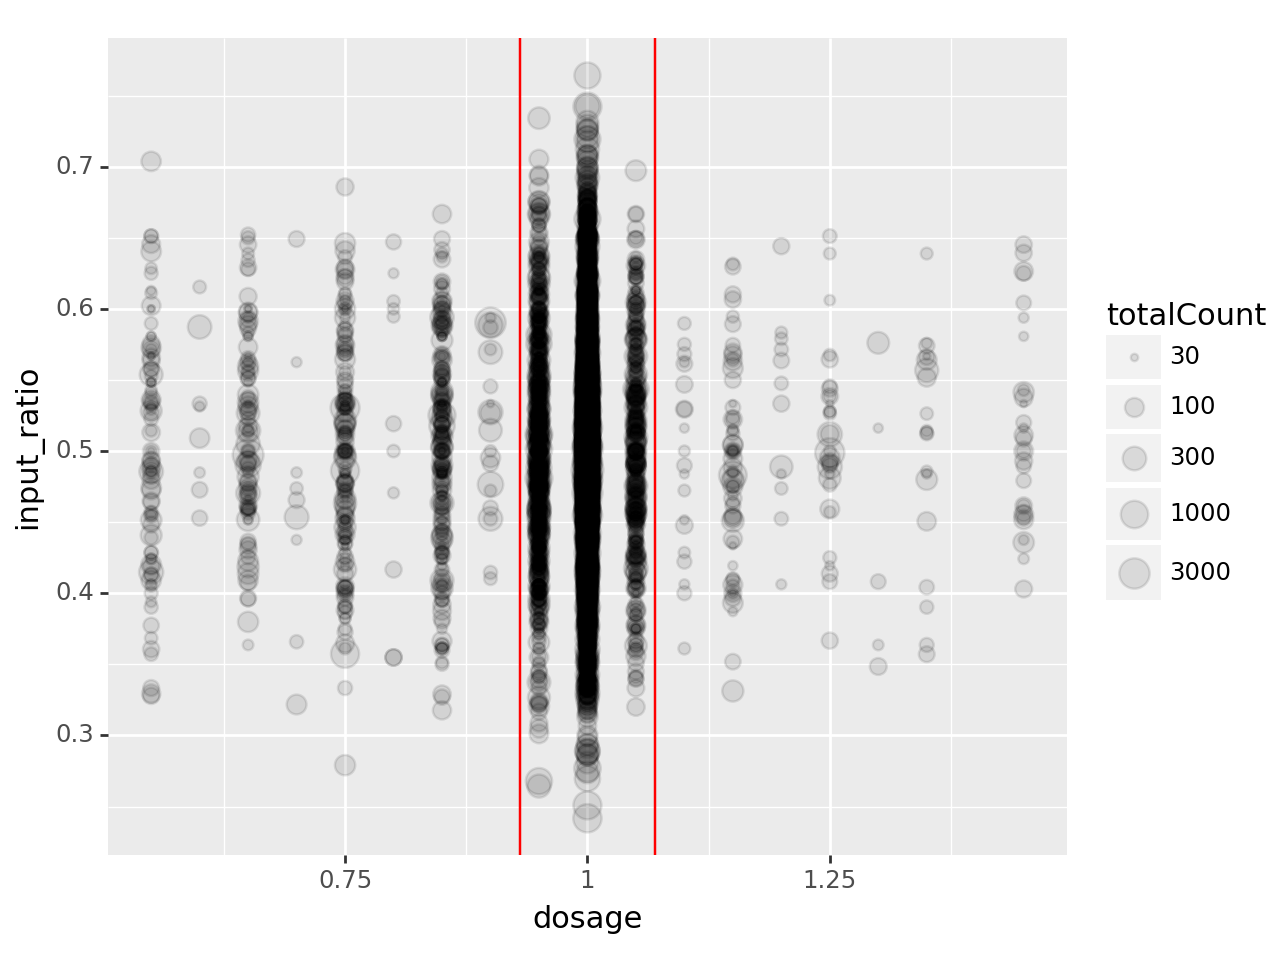

<Figure Size: (640 x 480)>

In [16]:
imp_merged["dosage"] = imp_merged.dosage1 + imp_merged.dosage2

import plotnine as p9
( p9.ggplot(imp_merged[imp_merged.totalCount >= 30], p9.aes("dosage", "input_ratio", size = "totalCount")) + 
 p9.geom_point(alpha = 0.1) + 
 p9.scale_size(trans = "log10") + 
 p9.geom_vline(xintercept = [.93,1.07], color = "red") )

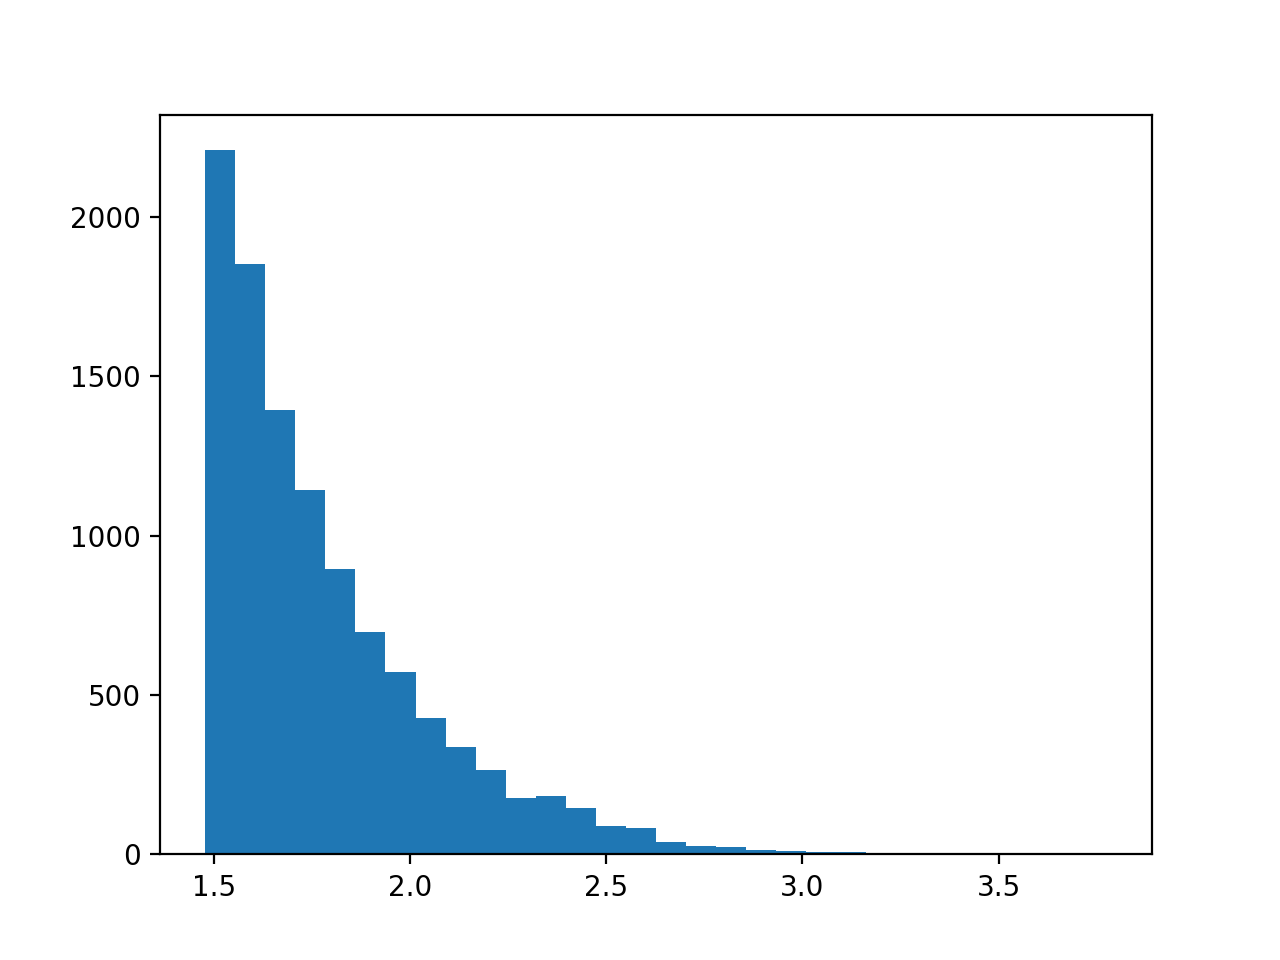

In [17]:
%matplotlib inline
_ = plt.hist(np.log10(imp_merged.totalCount), 30) # when/where did this get filtered?! only includes totalCount >= 10

In [18]:
het = imp_merged[np.logical_and(imp_merged.dosage > 0.93, imp_merged.dosage < 1.07)].copy()
het["phased_ratio"] = np.where(het.GT == "0|1", het.input_ratio, 1. - het.input_ratio)
het

contig  position_hg19   variantID refAllele altAllele   GT  dosage1  \
0      chr10         459940   rs4881274         G         A  0|1      0.0   
1      chr10        1034412  rs12772979         C         T  0|1      0.0   
2      chr10        1046712   rs2306409         G         A  1|0      1.0   
3      chr10        1090469  rs66797613         C         T  0|1      0.0   
4      chr10        3150898  rs11251721         C         T  1|0      1.0   
...      ...            ...         ...       ...       ...  ...      ...   
10616   chr9      139617662     rs11849         T         C  1|0      1.0   
10617   chr9      139618283      rs6873         A         G  1|0      1.0   
10618   chr9      139619366      rs6866         C         G  1|0      1.0   
10619   chr9      140084376  rs11556580         G         A  1|0      1.0   
10620   chr9      140084485   rs3087779         G         A  1|0      1.0   

       dosage2   position  refCount  altCount  totalCount  input_ratio  \
0         1.00     414000        20        18          38     0.473684   
1         0.95     988472        13        24          37     0.648649   
2         0.00    1000772        51        74         125     0.592000   
3         1.00    1044529        21        13          34     0.382353   
4         0.00    3108706        53        49         102     0.480392   
...        ...        ...       ...       ...         ...          ...   
10616     0.00  136723210        25        22          47     0.468085   
10617     0.00  136723831        34        31          65     0.476923   
10618     0.00  136724914        33        32          65     0.492308   
10619     0.05  137189924        41        48          89     0.539326   
10620     0.05  137190033        31        31          62     0.500000   

       dosage  phased_ratio  
0        1.00      0.473684  
1        0.95      0.648649  
2        1.00      0.408000  
3        1.00      0.382353  
4        1.00      0.519608  
...       ...           ...  
10616    1.00      0.531915  
10617    1.00      0.523077  
10618    1.00      0.507692  
10619    1.05      0.460674  
10620    1.05      0.500000  

[9815 rows x 15 columns]

In [19]:
from sklearn.neighbors import NearestNeighbors

dists = []
rats = []

for chrom in range(1,23):
    print(chrom, end = "\r")
    chrdat = het[het.contig == ("chr%i" % chrom)]
    chrdat = chrdat[chrdat.totalCount >= 30]
    X = chrdat.position.to_numpy().reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    distances, indices = nbrs.radius_neighbors(X, radius = 2000)
    phased_ratio = chrdat.phased_ratio.to_numpy()
    ratios = np.concatenate([ (phased_ratio[i] - phased_ratio[j]) for i,j in enumerate(indices) ])
    dist = np.concatenate(distances)
    to_keep = dist > 0
    dists.append( dist[to_keep] )
    rats.append( ratios[to_keep] )


In [20]:
p = het.phased_ratio[het.totalCount >= 30]
s = p.std()
np.sqrt(2.) * s

0.10428365066805474

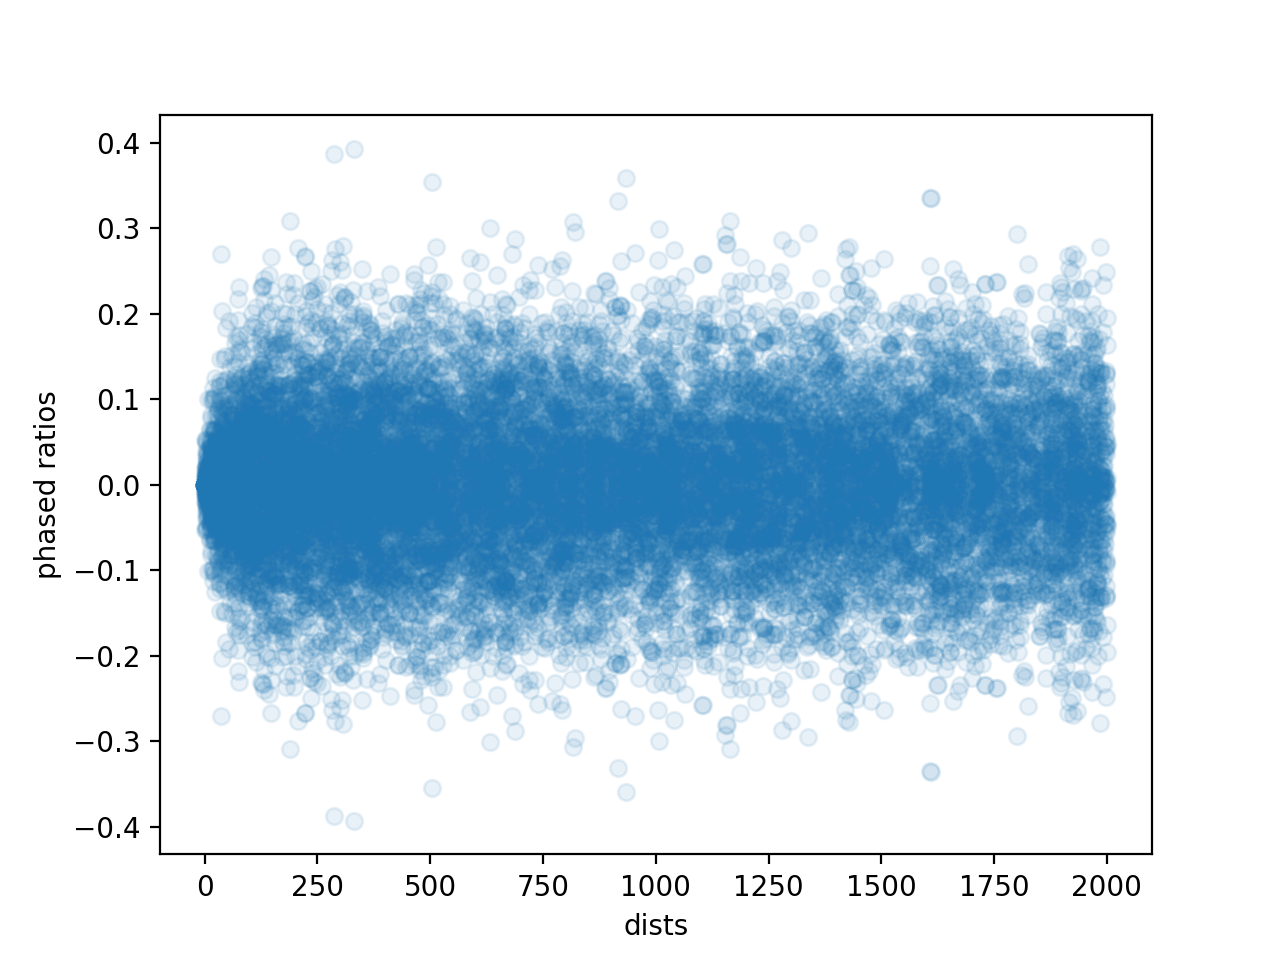

In [21]:
dist = np.concatenate(dists)
ratios = np.concatenate(rats)
plt.scatter(dist, ratios, alpha = 0.1)
plt.xlabel("dists")
plt.ylabel("phased ratios")
plt.show()

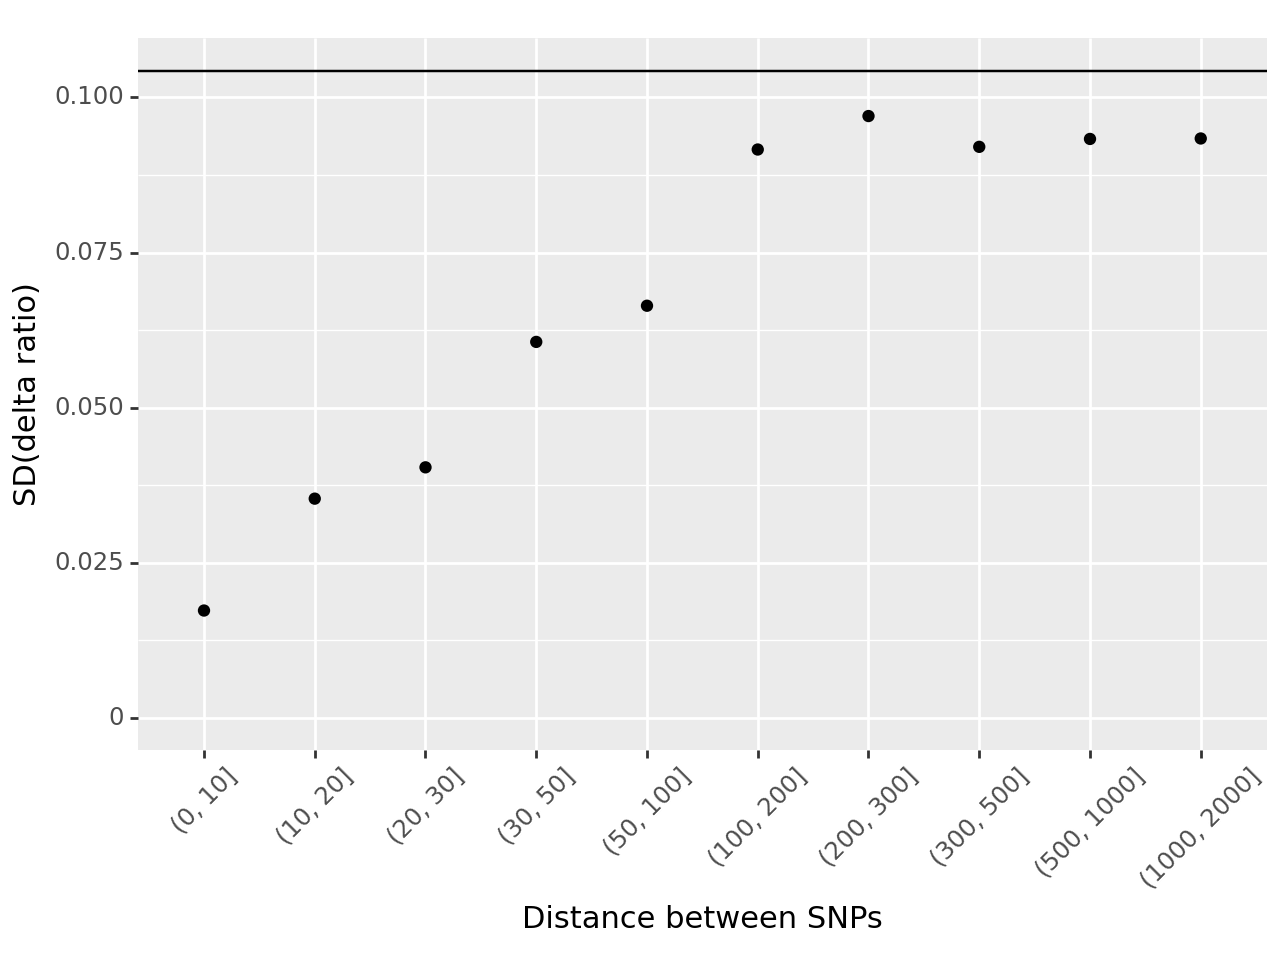

<Figure Size: (640 x 480)>

In [22]:
delta = pd.DataFrame({ "dist" : dist, "delta_ratio" : ratios})
delta["dist_discrete"] = pd.cut(
    delta.dist,
    bins=[0, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000])

summed = delta.groupby('dist_discrete', as_index=False).agg({'delta_ratio' : 'std'})

( p9.ggplot(summed, p9.aes("dist_discrete", 'delta_ratio')) + 
 p9.geom_point() + 
 p9.theme(axis_text_x = p9.element_text(angle = 45)) + 
 p9.ylab("SD(delta ratio)") + 
 p9.xlab("Distance between SNPs") + 
 p9.geom_hline(yintercept = np.sqrt(2.) * s) +
 p9.expand_limits(y = [0])
)

In [23]:
from pooledQTL import interval_utils

exons = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/gencode.v38.exons.txt.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons

In [24]:
len(chroms)

3038869

In [25]:
sanger.shape

(34582504, 16)

In [85]:
#exons_tree = interval_utils.to_interval_trees(exons, chroms)
#overlap["exonic"] = interval_utils.get_overlap(exons_tree, overlap)

In [26]:
genes = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/genes.tsv.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
genes = genes[genes.end - genes.start >= 100]

In [39]:
#genes_tree = interval_utils.to_interval_trees(genes, chroms)
#
#overlap["genic"] = interval_utils.get_overlap(genes_tree, overlap)

# Load IP count data and join with input and genotype

<Axes: >

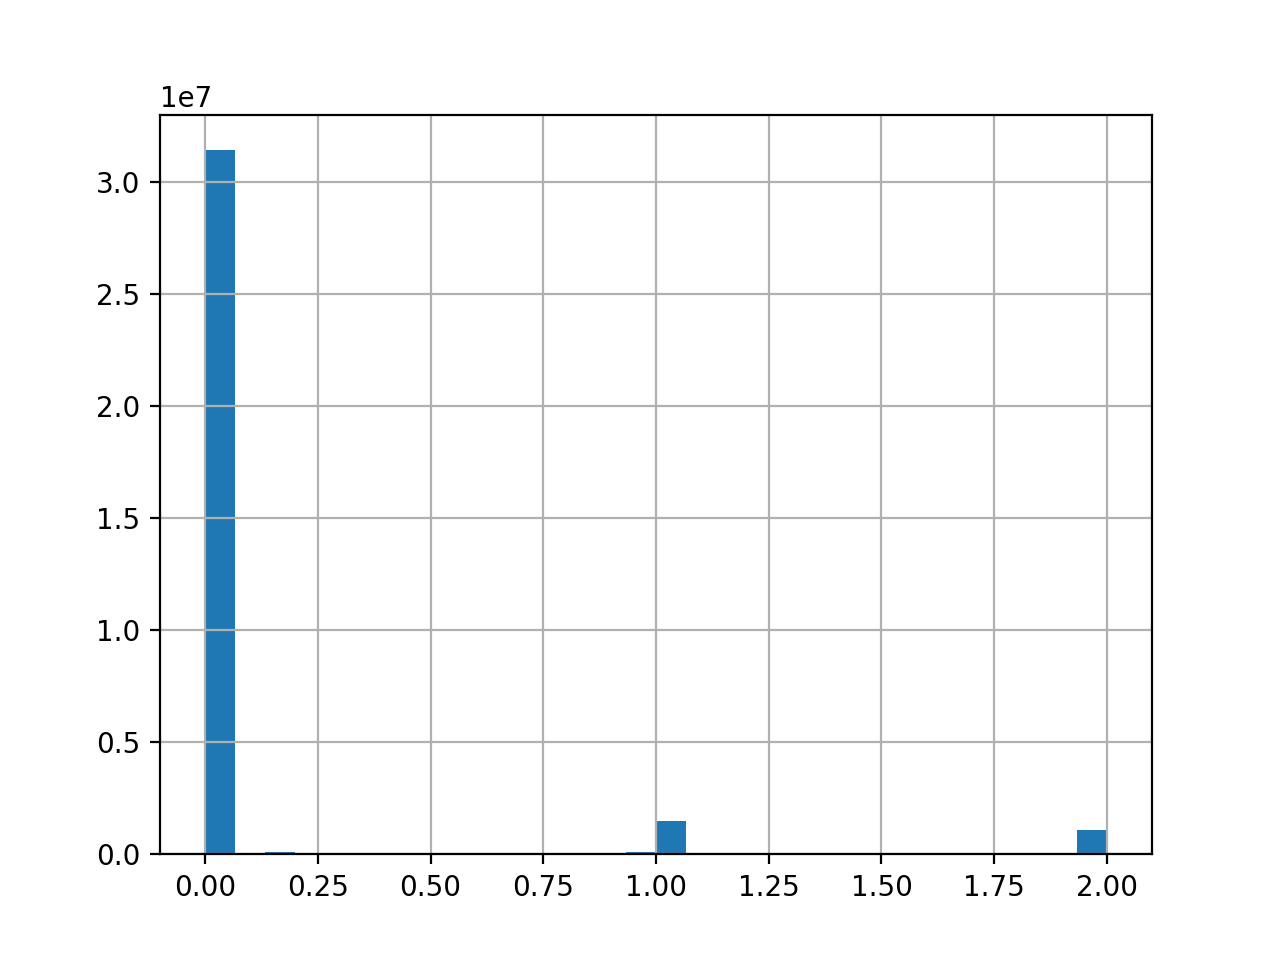

In [27]:
%matplotlib inline
sanger[sample_ind].hist(bins=30)

In [28]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[52.895062]

In [29]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[0.8851]

Joining genotype and input allelic counts. 
Have to match on rsID because sanger.vcf is hg19 and allelic counts are on hg38


In [30]:
sanger

contig   position          SNP refAllele altAllele  \
0         chr10      60494  rs568182971         A         G   
1         chr10      60523  rs112920234         T         G   
2         chr10      60803  rs536478188         T         G   
3         chr10      61020  rs115033199         G         C   
4         chr10      61314  rs569207726         T         C   
...         ...        ...          ...       ...       ...   
39131573   chr9  141111414  rs558431167         G         A   
39131574   chr9  141112371  rs563889179         G         A   
39131575   chr9  141127361  rs528107815         G         A   
39131576   chr9  141127558  rs553270612         G         C   
39131577   chr9  141127812  rs530585350         G         T   

          CW30274-1-1194512543_CW30274-1-1194512543  \
0                                               0.1   
1                                               0.1   
2                                               0.1   
3                                               0.1   
4                                               0.1   
...                                             ...   
39131573                                        0.0   
39131574                                        0.0   
39131575                                        0.0   
39131576                                        0.0   
39131577                                        0.0   

          CW30454-1-1194512472_CW30454-1-1194512472  \
0                                               0.1   
1                                               0.1   
2                                               0.1   
3                                               0.1   
4                                               0.1   
...                                             ...   
39131573                                        0.0   
39131574                                        0.0   
39131575                                        0.0   
39131576                                        0.0   
39131577                                        0.0   

          CW30421-1-1194512512_CW30421-1-1194512512  \
0                                               0.1   
1                                               0.1   
2                                               0.1   
3                                               0.1   
4                                               0.1   
...                                             ...   
39131573                                        0.0   
39131574                                        0.0   
39131575                                        0.0   
39131576                                        0.0   
39131577                                        0.0   

          CW70372-1-1194512488_CW70372-1-1194512488  \
0                                               0.1   
1                                               0.1   
2                                               0.1   
3                                               0.1   
4                                               0.1   
...                                             ...   
39131573                                        0.0   
39131574                                        0.0   
39131575                                        0.0   
39131576                                        0.0   
39131577                                        0.0   

          CW40201-1-1194512480_CW40201-1-1194512480  \
0                                               0.1   
1                                               0.1   
2                                               0.1   
3                                               0.1   
4                                               0.1   
...                                             ...   
39131573                                        0.0   
39131574                                        0.0   
39131575                                        0.0   
39131576                                        0.0   
391

In [52]:
dat = input_counts[0]
dat_IP = IP_counts[0]

dat = dat.rename(columns={ "chrom":"contig" })
dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = sanger.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
# there are only 0.08% flipped alleles so not worth doing.
# np.isnan(imp_merged.iloc[:,5:16]).any() all False
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount

In [53]:
imp_merged.shape

(10597, 21)

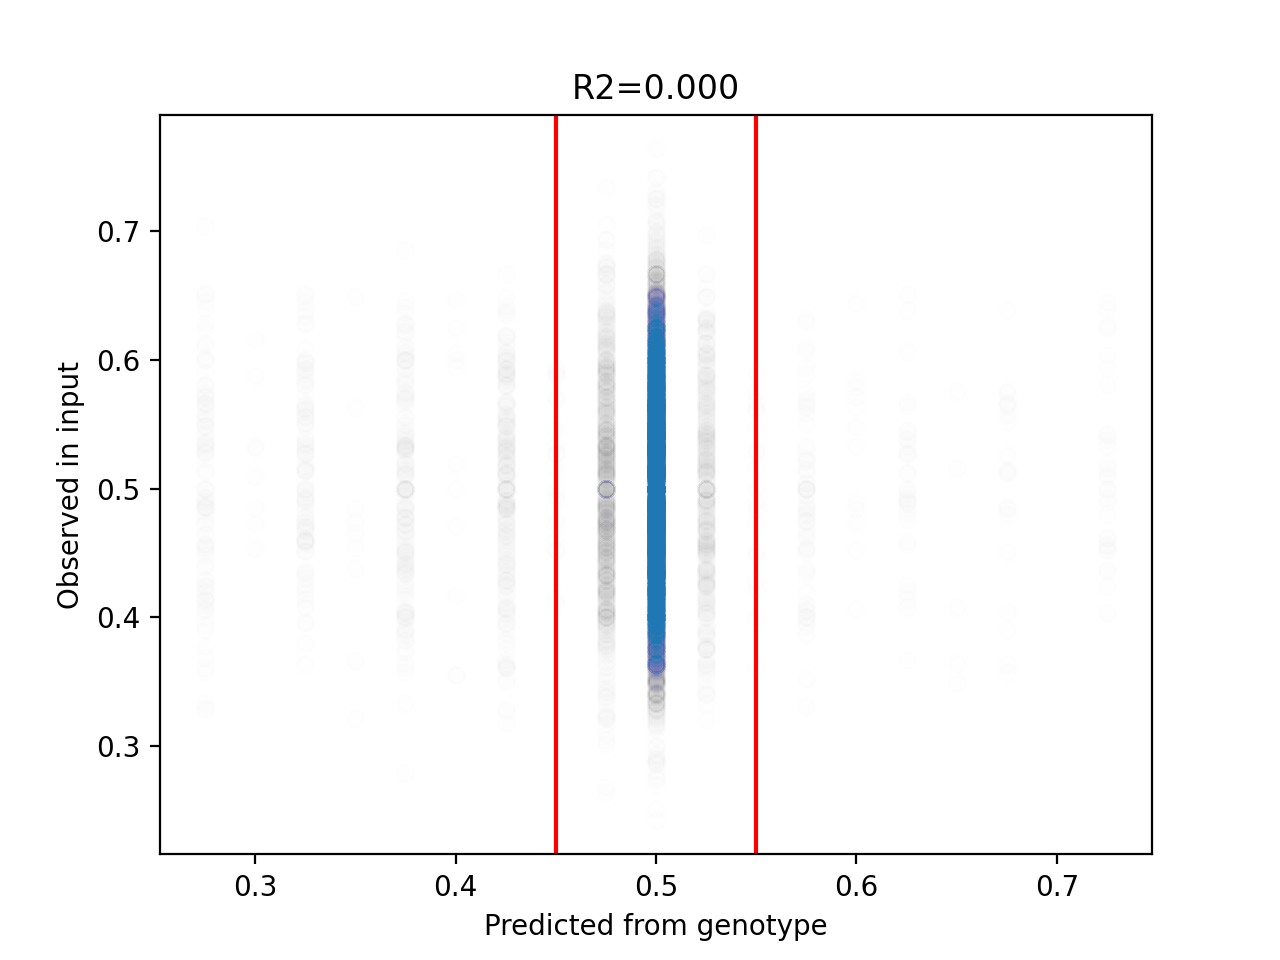

In [54]:
imp_merged["pred_ratio"] = 0.5 * imp_merged.loc[:,sample_ind].to_numpy()

imp_merged_30 = imp_merged[imp_merged.totalCount >= 30]
corr,_ = scipy.stats.pearsonr(imp_merged_30.pred_ratio, imp_merged_30.input_ratio)
R2 = corr*corr
plt.scatter(imp_merged_30.pred_ratio, imp_merged_30.input_ratio, alpha = 0.005) 
plt.title("R2=%.3f" % R2)
plt.xlabel("Predicted from genotype")
plt.ylabel("Observed in input")
plt.axvline(x = 0.45, color = 'r')
plt.axvline(x = 0.55, color = 'r')
plt.show()

Joining genotype+input with IP allelic counts

In [55]:
imp_merged

contig  position_hg19   variantID refAllele altAllele  \
0      chr10         459940   rs4881274         G         A   
1      chr10        1034412  rs12772979         C         T   
2      chr10        1046712   rs2306409         G         A   
3      chr10        1090469  rs66797613         C         T   
4      chr10        3150898  rs11251721         C         T   
...      ...            ...         ...       ...       ...   
10592   chr9      139617662     rs11849         T         C   
10593   chr9      139618283      rs6873         A         G   
10594   chr9      139619366      rs6866         C         G   
10595   chr9      140084376  rs11556580         G         A   
10596   chr9      140084485   rs3087779         G         A   

       CW30274-1-1194512543_CW30274-1-1194512543  \
0                                            0.0   
1                                            1.0   
2                                            0.0   
3                                            1.0   
4                                            0.0   
...                                          ...   
10592                                        0.0   
10593                                        0.0   
10594                                        0.0   
10595                                        0.0   
10596                                        0.0   

       CW30454-1-1194512472_CW30454-1-1194512472  \
0                                           2.00   
1                                           1.95   
2                                           0.05   
3                                           1.00   
4                                           0.00   
...                                          ...   
10592                                       2.00   
10593                                       2.00   
10594                                       2.00   
10595                                       0.00   
10596                                       0.00   

       CW30421-1-1194512512_CW30421-1-1194512512  \
0                                            1.0   
1                                            0.0   
2                                            1.0   
3                                            0.0   
4                                            1.0   
...                                          ...   
10592                                        0.0   
10593                                        0.0   
10594                                        0.0   
10595                                        0.0   
10596                                        0.0   

       CW70372-1-1194512488_CW70372-1-1194512488  \
0                                            0.0   
1                                            0.0   
2                                            2.0   
3                                            0.0   
4                                            0.1   
...                                          ...   
10592                                        0.0   
10593                                        0.0   
10594                                        0.0   
10595                                        0.0   
10596                                        0.0   

       CW40201-1-1194512480_CW40201-1-1194512480  ...  \
0                                           2.00  ...   
1                                           0.00  ...   
2                                           1.00  ...   
3                                           0.00  ...   
4                                           0.85  ...   
...                                          ...  ...   
10592                                       1.00  ...   
10593                                       1.00  ...   
10594                                       1.00  ...   
10595                                       0.00  ...   
10596                                       0.00  ...   

       CW30108-1-1194512496_CW30108-1-1194512496  \
0           

In [56]:
merged = imp_merged.drop(
    labels=sanger.columns[range(5,16)], axis=1 # # .rename(columns={"position_y":"position"} # ,"contig_x":"contig" ?
).merge(
    dat_IP, 
    on = ("contig", "position", "variantID", "refAllele", "altAllele"), 
    suffixes = ("_input", "_IP"))
#merged = merged.drop(labels=["contig_y", "position_x" ], axis=1)

merged["IP_ratio"] = merged.altCount_IP / merged.totalCount_IP


# filter for reasonable counts -- previous method
#input_total_min = 10
#allele_count_min = 4 
#ip_total_min = 30
#dat_sub = merged[merged.totalCount_input >= input_total_min]
#dat_sub = dat_sub[dat_sub.refCount_input >= allele_count_min]
#dat_sub = dat_sub[dat_sub.altCount_input >= allele_count_min]
#dat_sub = dat_sub[dat_sub.totalCount_IP >= ip_total_min]
#dat_sub = dat_sub[dat_sub.pred_ratio >= 0.45]
#dat_sub = dat_sub[dat_sub.pred_ratio <= 0.55]

ip_total_min = 30
dat_sub = merged[merged.totalCount_IP >= ip_total_min]

In [61]:
dat_subsub = dat_sub[dat_sub.pred_ratio == 0.5]

<Axes: >

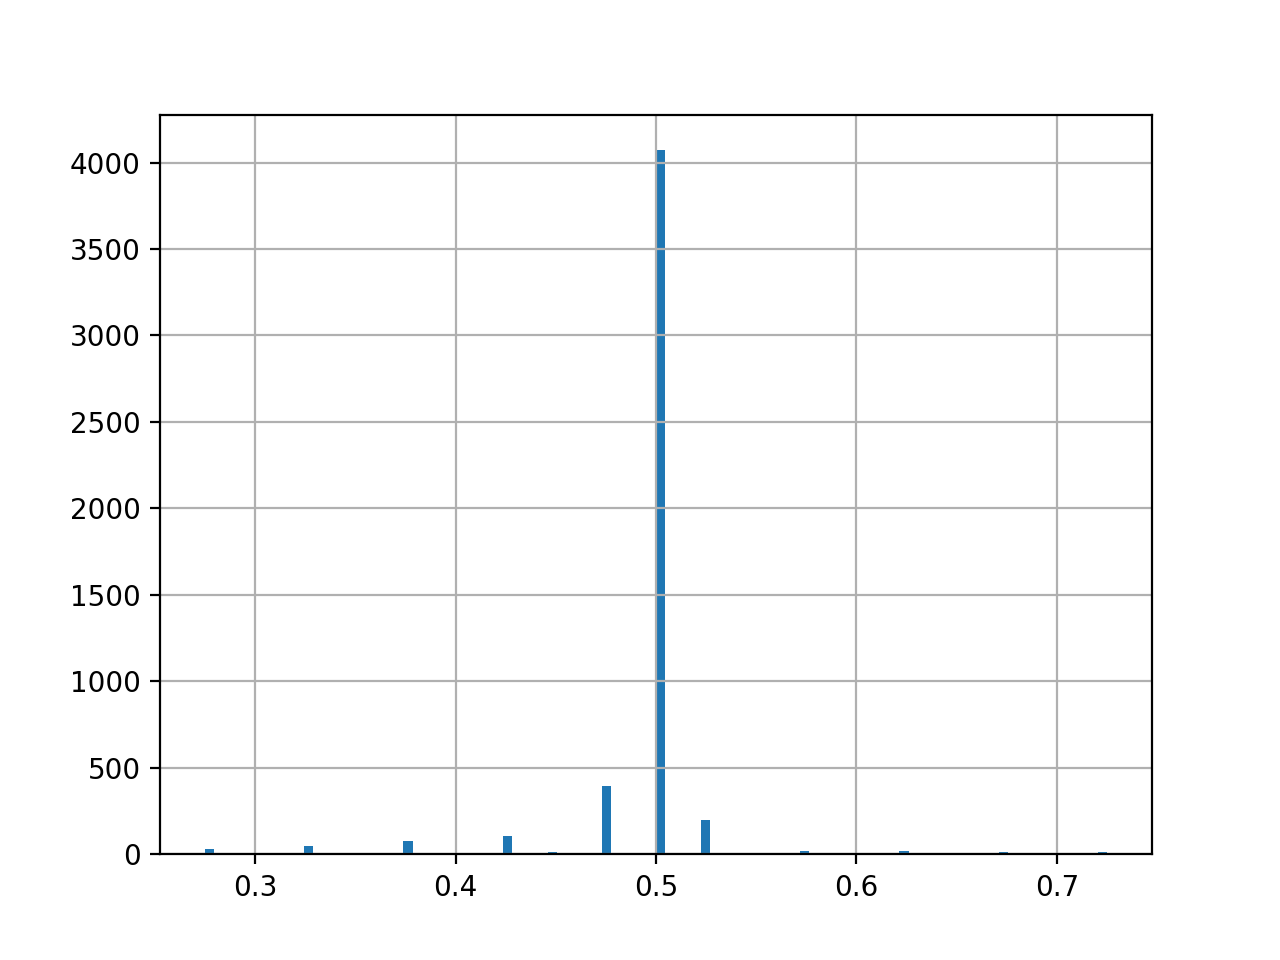

In [58]:
dat_sub.pred_ratio.hist(bins=100)

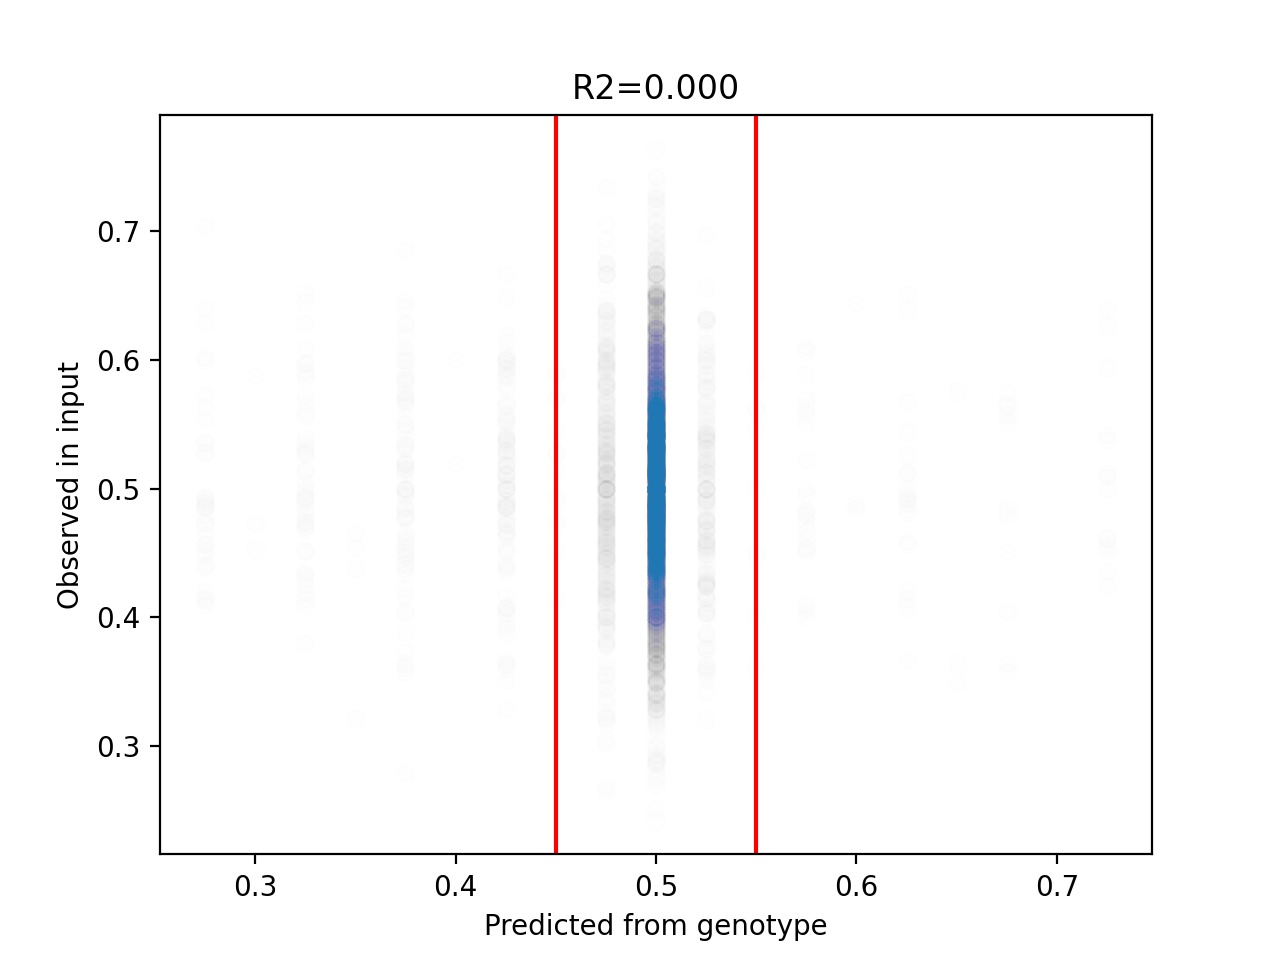

In [59]:
corr,_ = scipy.stats.pearsonr(dat_sub.pred_ratio, dat_sub.input_ratio)
R2 = corr*corr
plt.scatter(dat_sub.pred_ratio, dat_sub.input_ratio, alpha = 0.005) 
plt.title("R2=%.3f" % R2)
plt.xlabel("Predicted from genotype")
plt.ylabel("Observed in input")
plt.axvline(x = 0.45, color = 'r')
plt.axvline(x = 0.55, color = 'r')
plt.show()

In [60]:
dat_sub

contig  position_hg19   variantID refAllele altAllele   position  \
2     chr10        1046712   rs2306409         G         A    1000772   
5     chr10        3150973   rs1132173         C         T    3108781   
6     chr10        3155353   rs3816699         C         T    3113161   
7     chr10        5499173     rs11791         A         G    5457210   
8     chr10        5743814  rs72774061         A         G    5701851   
...     ...            ...         ...       ...       ...        ...   
9073   chr9      139335599   rs1127152         A         G  136441147   
9075   chr9      139371786   rs6560632         A         C  136477334   
9078   chr9      139618283      rs6873         A         G  136723831   
9079   chr9      139619366      rs6866         C         G  136724914   
9080   chr9      140084376  rs11556580         G         A  137189924   

      refCount_input  altCount_input  totalCount_input  input_ratio  \
2                 51              74               125     0.592000   
5                 43              45                88     0.511364   
6                 42              45                87     0.517241   
7                 51              64               115     0.556522   
8                 17              13                30     0.433333   
...              ...             ...               ...          ...   
9073              37              19                56     0.339286   
9075              43              24                67     0.358209   
9078              34              31                65     0.476923   
9079              33              32                65     0.492308   
9080              41              48                89     0.539326   

      pred_ratio  refCount_IP  altCount_IP  totalCount_IP  IP_ratio  
2          0.500           34           13             47  0.276596  
5          0.500           12           24             36  0.666667  
6          0.475           16           41             57  0.719298  
7          0.500           31           51             82  0.621951  
8          0.375           27           32             59  0.542373  
...          ...          ...          ...            ...       ...  
9073       0.500           36           18             54  0.333333  
9075       0.500           45           20             65  0.307692  
9078       0.500           31            6             37  0.162162  
9079       0.500           24            8             32  0.250000  
9080       0.525            7           35             42  0.833333  

[5028 rows x 15 columns]

In [93]:
results.columns

Index(['contig', 'position_hg19', 'variantID', 'refAllele', 'altAllele',
       'position', 'refCount_input', 'altCount_input', 'totalCount_input',
       'pred_ratio', 'refCount_IP', 'altCount_IP', 'totalCount_IP',
       'shrunk_input_logratio', 'ase_loc', 'ase_sd', 'ase_q',
       'shrunk_IP_logratio', 'asb_loc', 'asb_sd', 'asb_q', 'in_peak',
       'in_exon', 'in_transcript', 'in_gene', 'in_utr'],
      dtype='object')

contig  position_hg19   variantID refAllele altAllele   position  \
0     chr10         459940   rs4881274         G         A     414000   
1     chr10        1034412  rs12772979         C         T     988472   
2     chr10        1046712   rs2306409         G         A    1000772   
3     chr10        1090469  rs66797613         C         T    1044529   
4     chr10        3150898  rs11251721         C         T    3108706   
...     ...            ...         ...       ...       ...        ...   
9077   chr9      139617662     rs11849         T         C  136723210   
9078   chr9      139618283      rs6873         A         G  136723831   
9079   chr9      139619366      rs6866         C         G  136724914   
9080   chr9      140084376  rs11556580         G         A  137189924   
9081   chr9      140084485   rs3087779         G         A  137190033   

      refCount_input  altCount_input  totalCount_input  input_ratio  \
0                 20              18                38     0.473684   
1                 13              24                37     0.648649   
2                 51              74               125     0.592000   
3                 21              13                34     0.382353   
4                 53              49               102     0.480392   
...              ...             ...               ...          ...   
9077              25              22                47     0.468085   
9078              34              31                65     0.476923   
9079              33              32                65     0.492308   
9080              41              48                89     0.539326   
9081              31              31                62     0.500000   

      pred_ratio  refCount_IP  altCount_IP  totalCount_IP  IP_ratio  
0          0.500           16           11             27  0.407407  
1          0.475            7           16             23  0.695652  
2          0.500           34           13             47  0.276596  
3          0.500            7           14             21  0.666667  
4          0.500           19            3             22  0.136364  
...          ...          ...          ...            ...       ...  
9077       0.500           11           12             23  0.521739  
9078       0.500           31            6             37  0.162162  
9079       0.500           24            8             32  0.250000  
9080       0.525            7           35             42  0.833333  
9081       0.525            8            4             12  0.333333  

[9082 rows x 15 columns]

In [ ]:
(merged.totalCount_input >= 30) & (merged.totalCount_IP >= 30) & 

In [ ]:
merged[(merged.IP_ratio >= 0.45) & (merged.IP_ratio <= 0.55)]

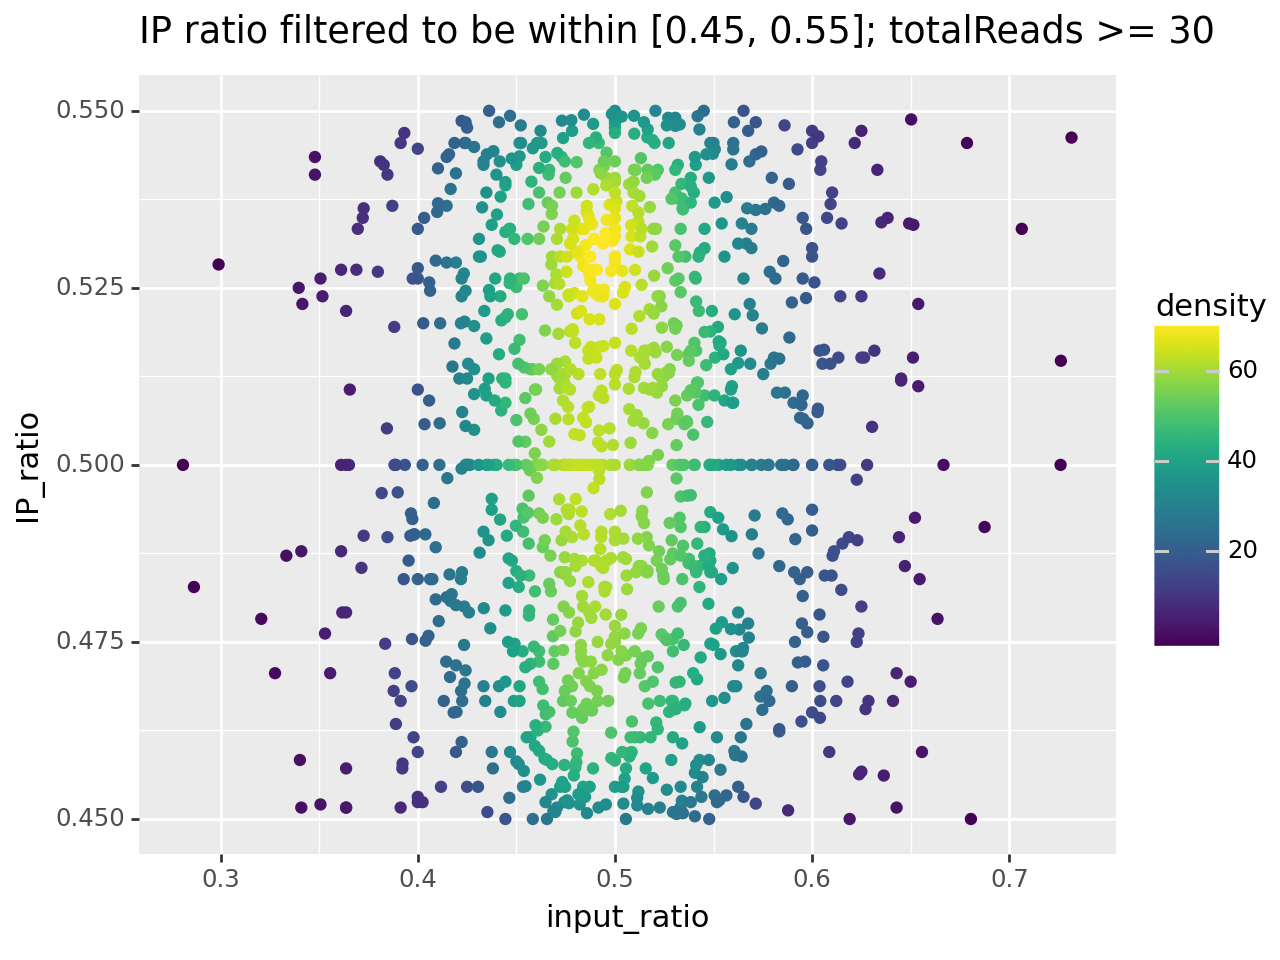

<Figure Size: (640 x 480)>

In [123]:
readThresh = 30
p = (p9.ggplot(merged[(merged.totalCount_input >= readThresh) & (merged.totalCount_IP >= readThresh) & (merged.IP_ratio >= 0.45) & (merged.IP_ratio <= 0.55)], p9.aes(x = "input_ratio", y = "IP_ratio")) +
     p9.geom_pointdensity()+
     p9.labs(title=f"IP ratio filtered to be within [0.45, 0.55]; totalReads >= {readThresh}")
)
p

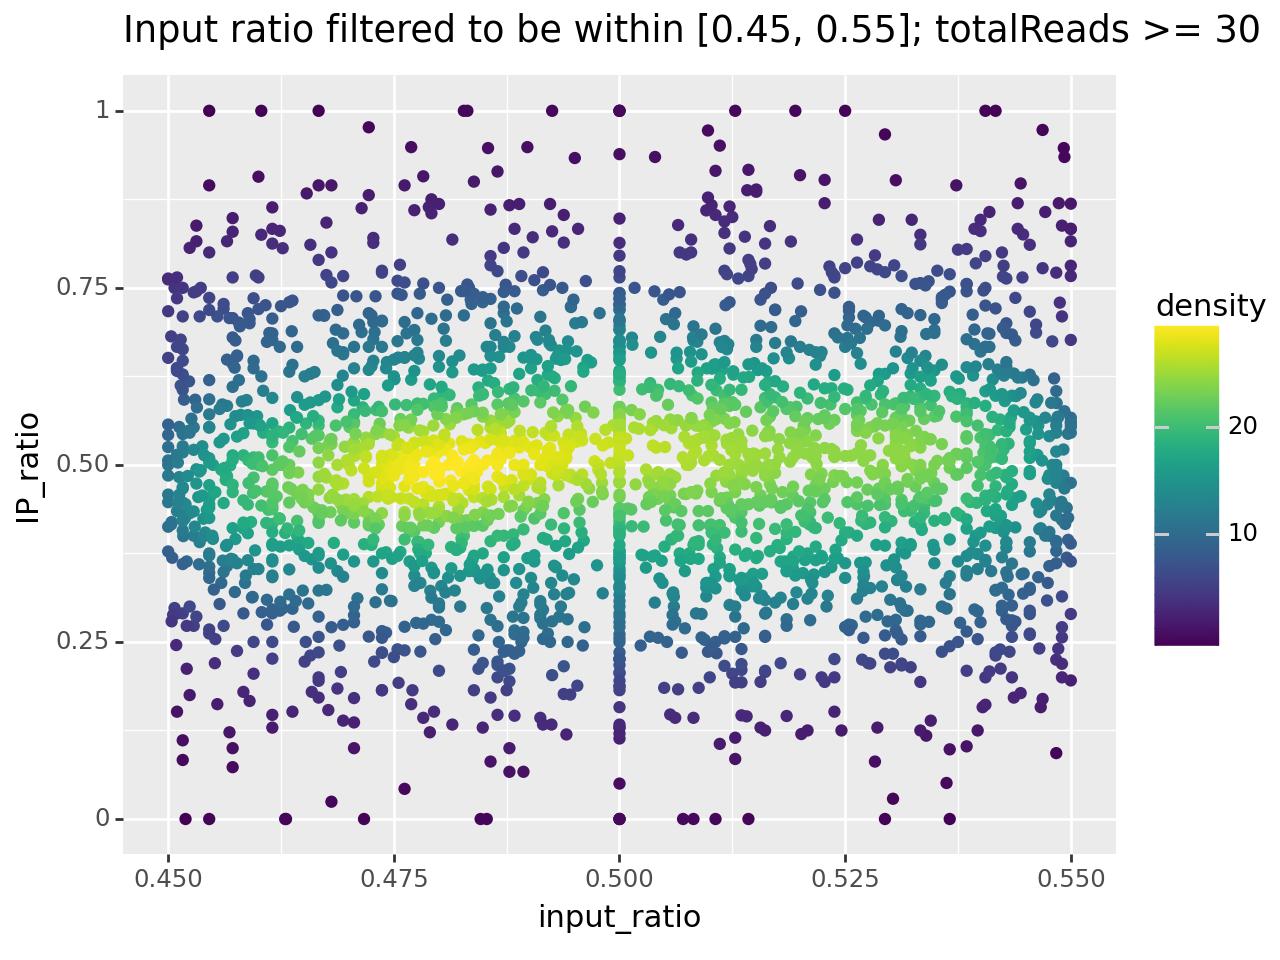

<Figure Size: (640 x 480)>

In [124]:
p = (p9.ggplot(merged[(merged.totalCount_input >= readThresh) & (merged.totalCount_IP >= readThresh) & (merged.input_ratio >= 0.45) & (merged.input_ratio <= 0.55)], p9.aes(x = "input_ratio", y = "IP_ratio")) +
     p9.geom_pointdensity()+
     p9.labs(title=f"Input ratio filtered to be within [0.45, 0.55]; totalReads >= {readThresh}")
)
p

In [126]:
readThresh

30

In [136]:
merged[(merged.totalCount_input >= readThresh) & (merged.totalCount_IP >= readThresh) & 
       (merged.input_ratio >= 0.45) & (merged.input_ratio <= 0.55) &
       ((merged.IP_ratio <= 0.05) | (merged.IP_ratio >= 0.95))].sort_values(by='totalCount_input', ascending=False).rename(columns={"contig": "chrom"}).to_csv(Path('/home/dmeyer/projects/bqtls/tdp43/filtered_epsilon0.3_totalReads30_IPoutliers.tsv'), sep="\t", index=False)

In [137]:
!rm /home/dmeyer/projects/bqtls/tdp43/filtered_epsilon0.3_totalReads30_struct_with_peaks_IPoutliers.tsv

In [134]:
filtered_epsilon0.3_totalReads30_IPoutliers.tsv
!rm /home/dmeyer/projects/bqtls/tdp43/filtered_epsilon0.4_totalReads30_struct_with_peaks_IPoutliers.tsv 

# Run beta models

In [63]:
from pathlib import PosixPath

In [66]:
results_dir = PosixPath('/home/dmeyer/projects/bqtls/tdp43')

In [65]:
results_file = results_dir / ("beta_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")

In [72]:
results_file = results_dir / ("beta_filtered_epsilon0.4_ipreads30_struct.tsv.gz")
print(results_file)
results = pd.read_csv(results_file, sep="\t")

/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.4_ipreads30_struct.tsv.gz


In [68]:
input_files

['/home/dmeyer/projects/bqtls/tdp43/tdp43_filtered_input_epsilon0.3.txt']

In [68]:
#epsilon = 0.4
#results = beta_model.fit_and_save(dat_subsub, 
#                                 results_dir / (f"beta_filtered_epsilon{epsilon}_totalreads30_struct.tsv.gz"),
#                                 use_structured_guide = True,
#                                 iterations = 1000,
#                                 device = device)
#results

In [71]:
epsilon = 0.4
results = beta_model.fit_and_save(dat_sub, 
                                 results_dir / (f"beta_filtered_epsilon{epsilon}_ipreads30_struct.tsv.gz"),
                                 use_structured_guide = True,
                                 iterations = 1000,
                                 device = device)
results

Learned hyperparameters: {'input_conc': 71.54956817626953, 'input_count_conc': 182.96324157714844, 'IP_conc': 12.681351661682129, 'IP_count_conc': 19.6523380279541}


contig  position_hg19   variantID refAllele altAllele   position  \
0     chr10        1046712   rs2306409         G         A    1000772   
1     chr10        3150973   rs1132173         C         T    3108781   
2     chr10        3155353   rs3816699         C         T    3113161   
3     chr10        5499173     rs11791         A         G    5457210   
4     chr10        5743814  rs72774061         A         G    5701851   
...     ...            ...         ...       ...       ...        ...   
5023   chr9      139335599   rs1127152         A         G  136441147   
5024   chr9      139371786   rs6560632         A         C  136477334   
5025   chr9      139618283      rs6873         A         G  136723831   
5026   chr9      139619366      rs6866         C         G  136724914   
5027   chr9      140084376  rs11556580         G         A  137189924   

      refCount_input  altCount_input  totalCount_input  input_ratio  ...  \
0                 51              74               125     0.592000  ...   
1                 43              45                88     0.511364  ...   
2                 42              45                87     0.517241  ...   
3                 51              64               115     0.556522  ...   
4                 17              13                30     0.433333  ...   
...              ...             ...               ...          ...  ...   
5023              37              19                56     0.339286  ...   
5024              43              24                67     0.358209  ...   
5025              34              31                65     0.476923  ...   
5026              33              32                65     0.492308  ...   
5027              41              48                89     0.539326  ...   

      totalCount_IP  IP_ratio  shrunk_input_logratio   ase_loc    ase_sd  \
0                47  0.276596               0.163033  0.163033  0.185467   
1                36  0.666667               0.100790  0.100790  0.150259   
2                57  0.719298               0.014202  0.114285  0.187896   
3                82  0.621951               0.117005  0.117005  0.151156   
4                59  0.542373              -0.476469  0.034356  0.197374   
...             ...       ...                    ...       ...       ...   
5023             54  0.333333              -0.272089 -0.272089  0.176804   
5024             65  0.307692              -0.203921 -0.203921  0.172275   
5025             37  0.162162              -0.087030 -0.087030  0.170313   
5026             32  0.250000              -0.078618 -0.078618  0.176474   
5027             42  0.833333               0.239986  0.139903  0.136583   

         ase_q  shrunk_IP_logratio   asb_loc    asb_sd     asb_q  
0     0.189691           -0.447333 -0.610366  0.366829  0.048066  
1     0.251182            0.394031  0.293241  0.419899  0.242475  
2     0.271516            0.513755  0.499553  0.336080  0.068585  
3     0.219446            0.407904  0.290899  0.329299  0.188513  
4     0.430907           -0.034924  0.441546  0.378671  0.121799  
...        ...                 ...       ...       ...       ...  
5023  0.061911           -0.534490 -0.262401  0.423731  0.267872  
5024  0.118266           -0.535307 -0.331386  0.435273  0.223230  
5025  0.304675           -0.746027 -0.658997  0.409822  0.053917  
5026  0.327982           -0.628294 -0.549677  0.412459  0.091318  
5027  0.152844            0.952260  0.712273  0.437507  0.051760  

[5028 rows x 23 columns]

In [70]:
results_file

PosixPath('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.4_ipreads30_struct.tsv.gz')

In [ ]:
results

In [107]:
list(results_dir.glob("*"))

[PosixPath('/home/dmeyer/projects/bqtls/tdp43/allelic'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/alignment'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/fastqc'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/peaks'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/features'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/beta_struct.tsv.gz'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/normal_struct.tsv.tsv.gz'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/normal_struct.tsv.json'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/beta_struct_results_with_peaks.tsv'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/tdp43_filtered_input.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.2_totalreads10_struct.tsv.gz'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.2_totalreads10_struct_with_peaks.tsv.gz'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43/tdp43_filtered_input_epsilon0.2.txt'),
 PosixPath('/home/dmeyer/projects/bqtls/tdp43

In [108]:
epsilon = 0.3
results_file = results_dir / (f"beta_filtered_epsilon{epsilon}_totalreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")

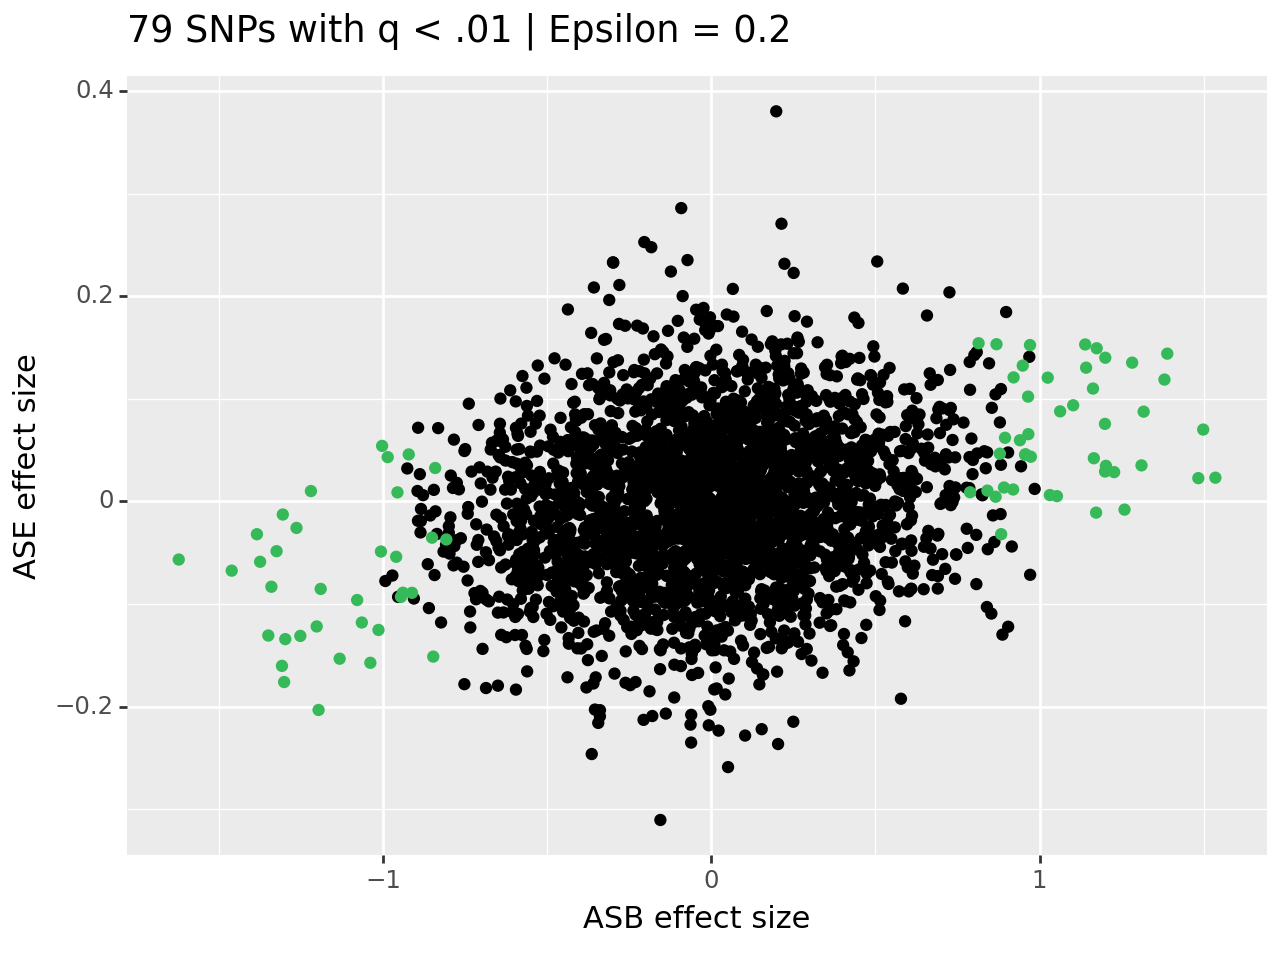

<Figure Size: (640 x 480)>

In [90]:
epsilon = 0.2
results_file = results_dir / (f"beta_filtered_epsilon{epsilon}_totalreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

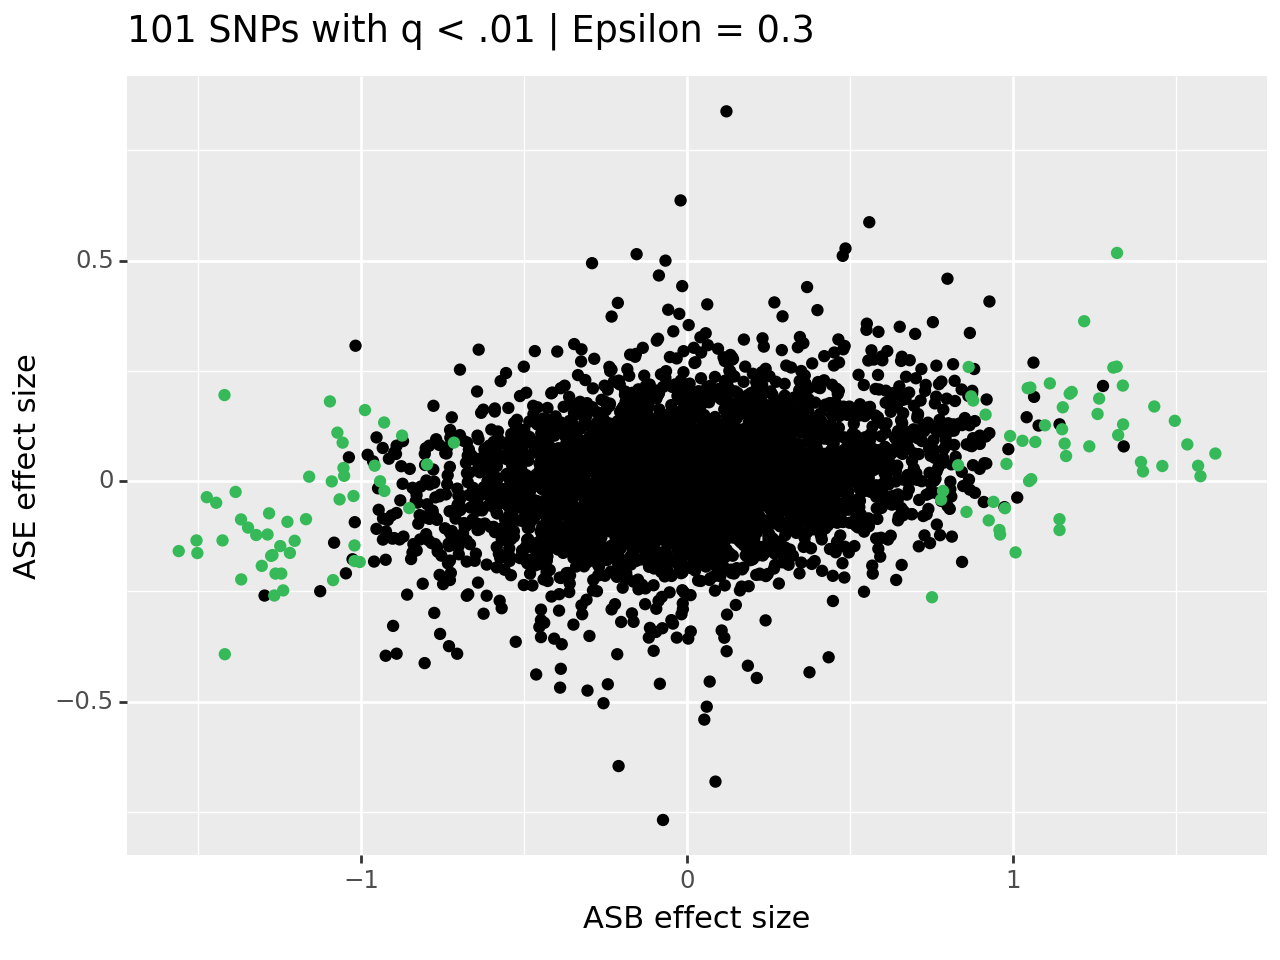

<Figure Size: (640 x 480)>

In [91]:
epsilon = 0.3
results_file = results_dir / (f"beta_filtered_epsilon{epsilon}_totalreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

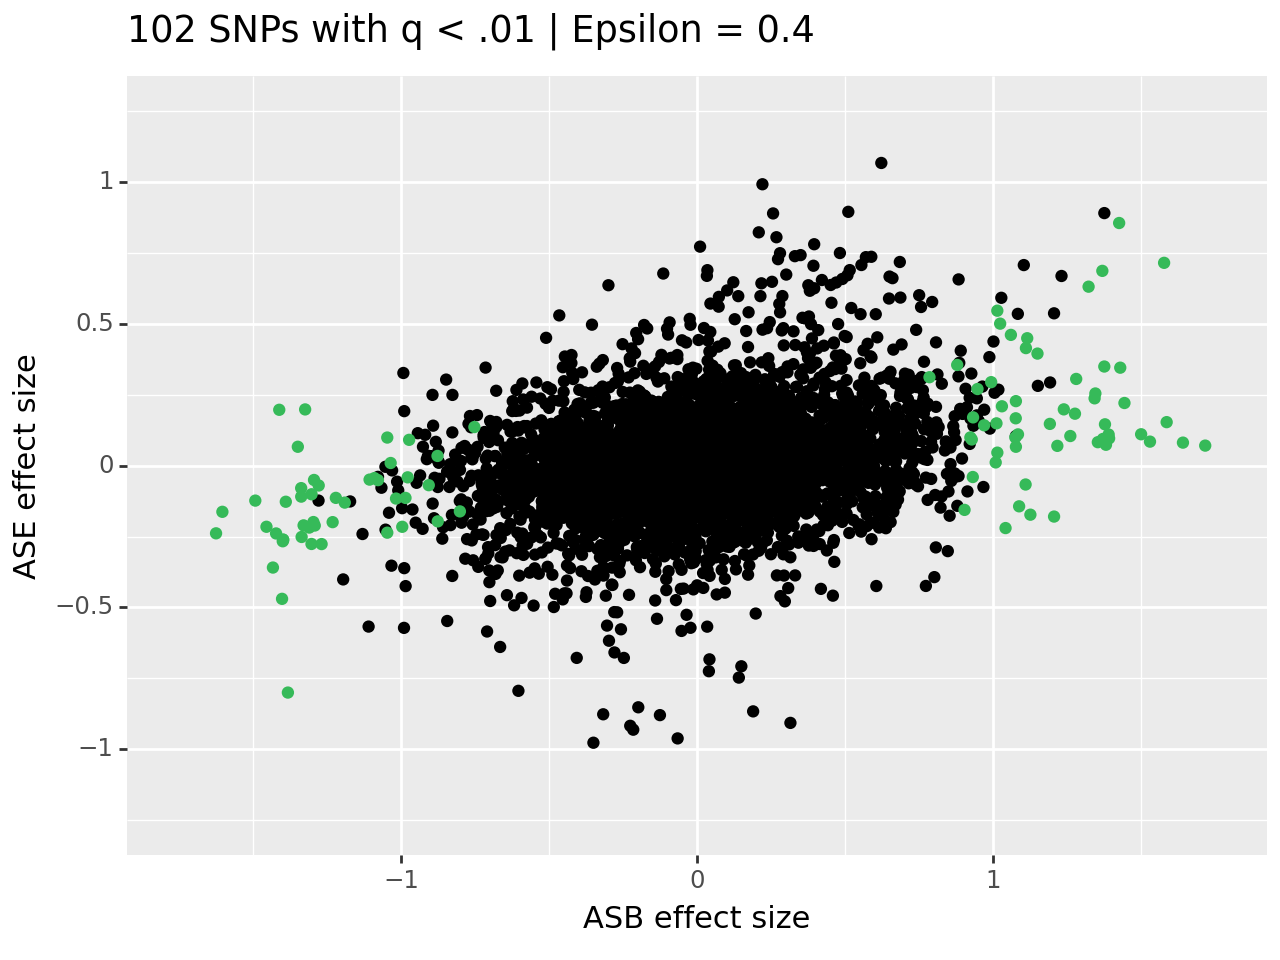

<Figure Size: (640 x 480)>

In [104]:
epsilon = 0.4
results_file = results_dir / (f"beta_filtered_epsilon{epsilon}_totalreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
     p9.lims(x=[-1.75, 1.75], y=[-1.25, 1.25])+
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

/home/dmeyer/.conda/envs/a/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


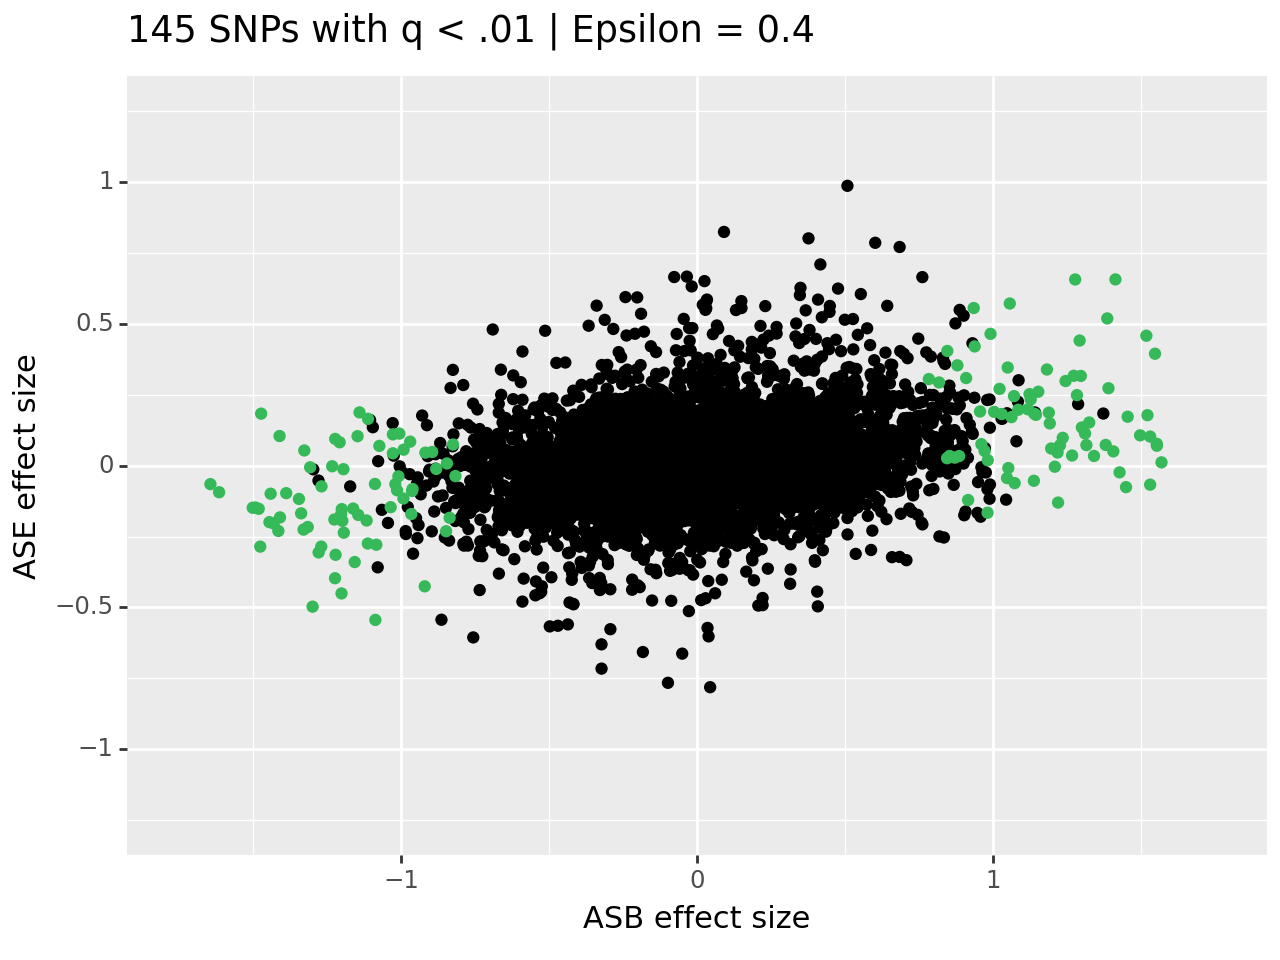

<Figure Size: (640 x 480)>

In [73]:
epsilon = 0.4
results_file = results_dir / (f"beta_filtered_epsilon{epsilon}_ipreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
     p9.lims(x=[-1.75, 1.75], y=[-1.25, 1.25])+
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

In [ ]:
ggplot_data.columns

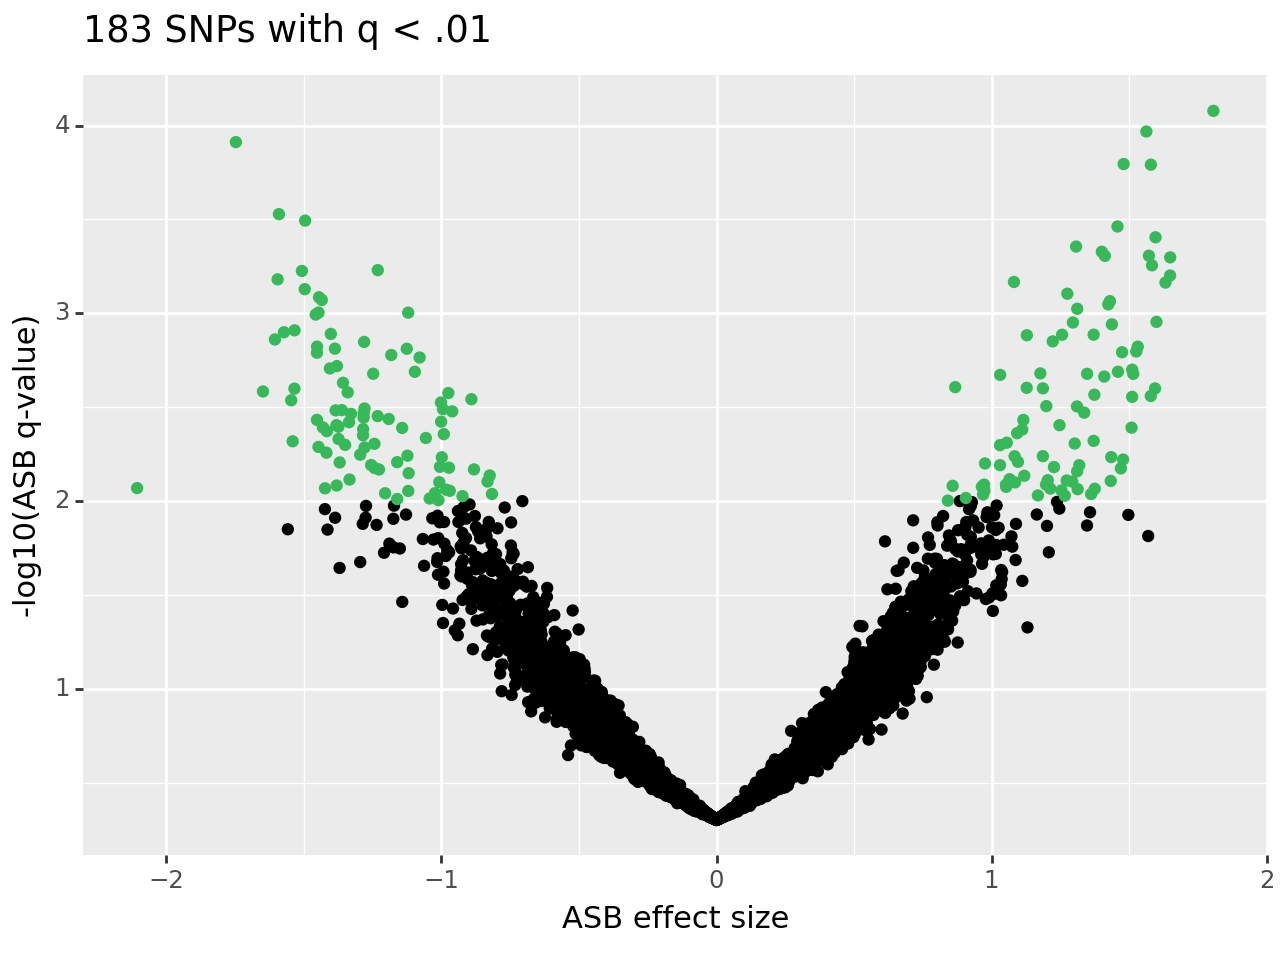

<Figure Size: (640 x 480)>

In [173]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "-np.log10(asb_q)")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
    p9.labs(x = "ASB effect size", y = "-log10(ASB q-value)", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

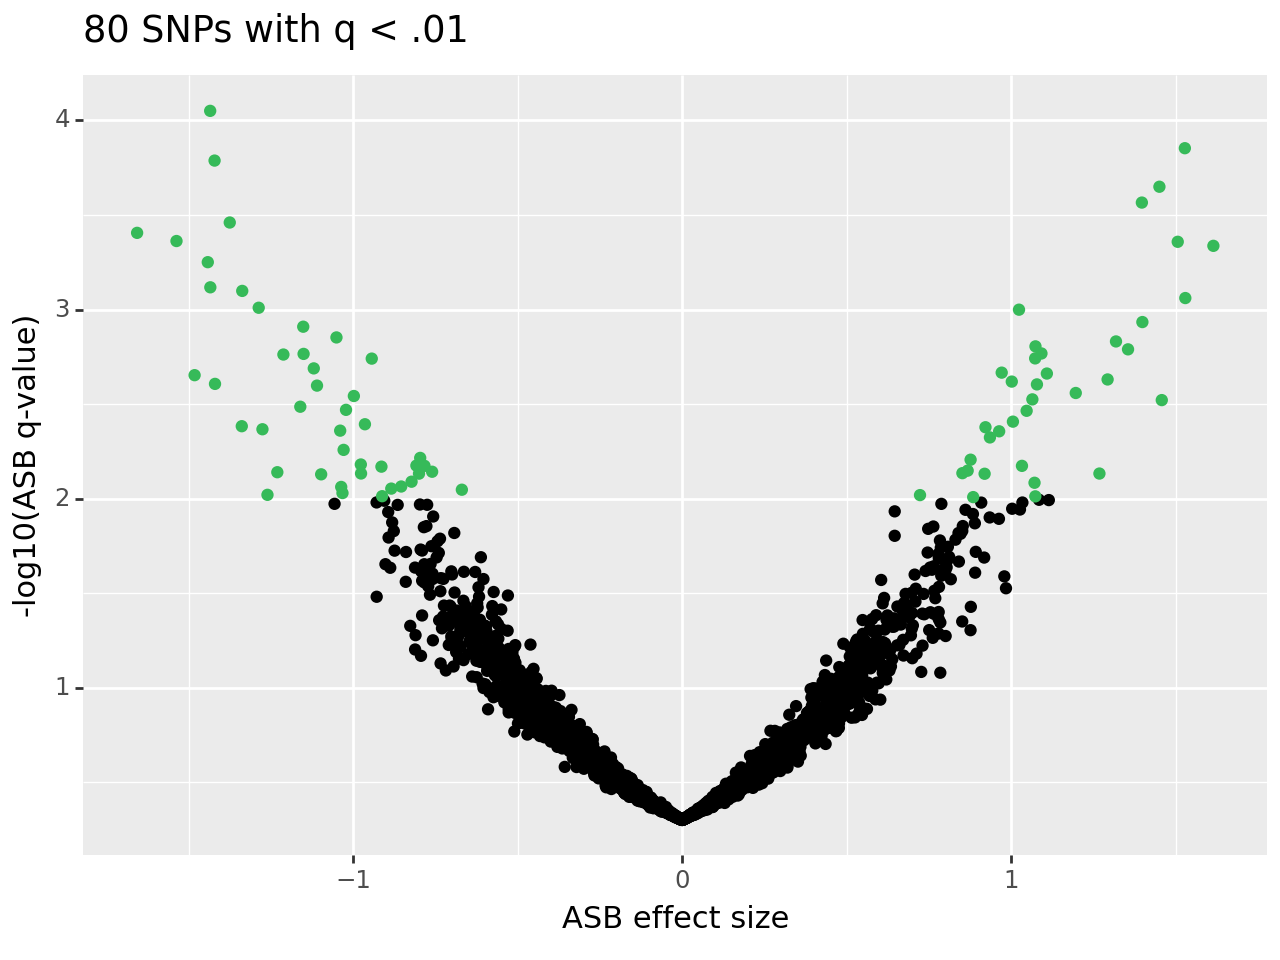

<Figure Size: (640 x 480)>

In [83]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "-np.log10(asb_q)")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
    p9.labs(x = "ASB effect size", y = "-log10(ASB q-value)", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

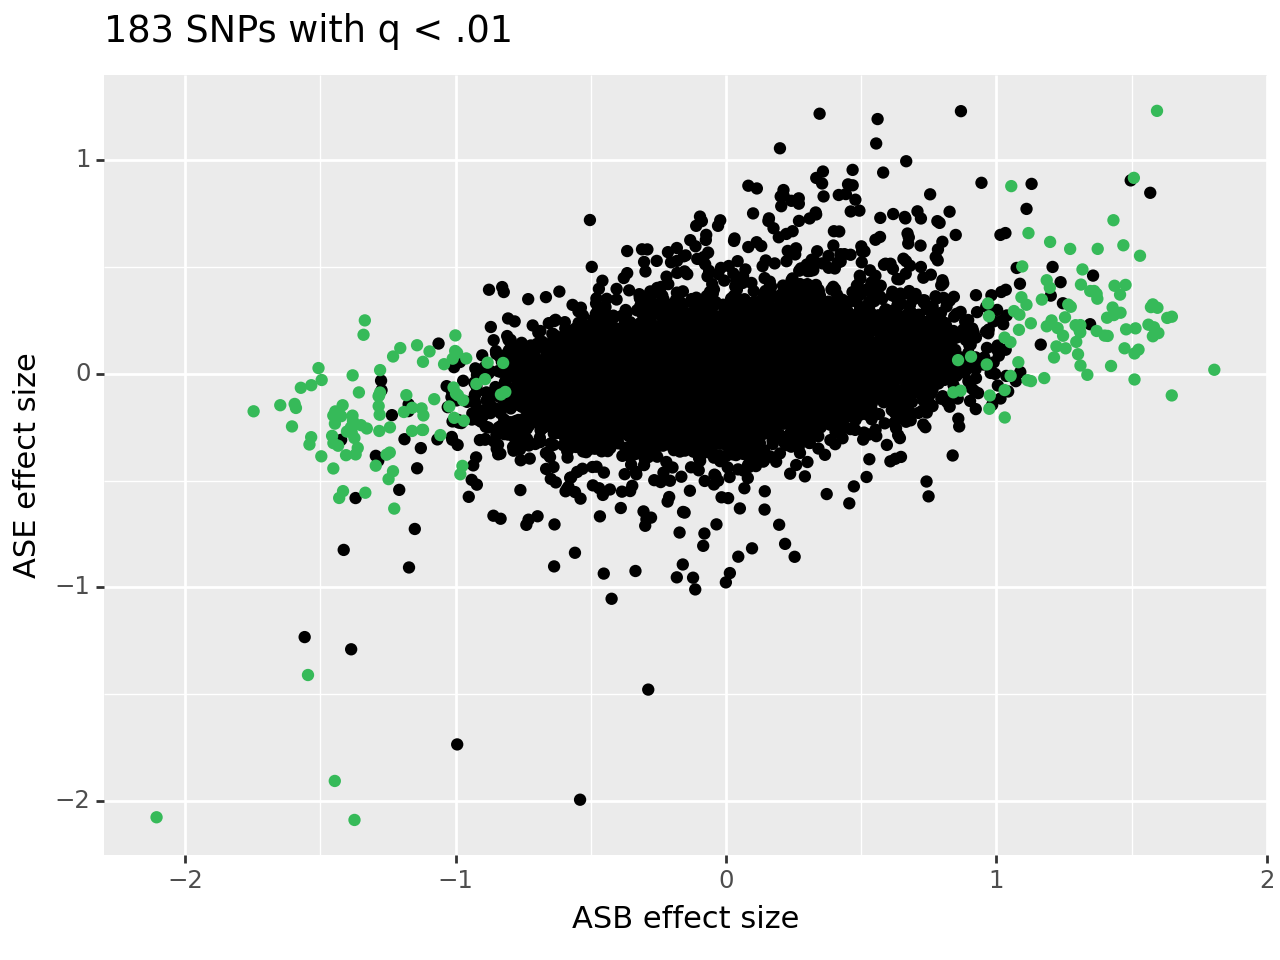

<Figure Size: (640 x 480)>

In [175]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

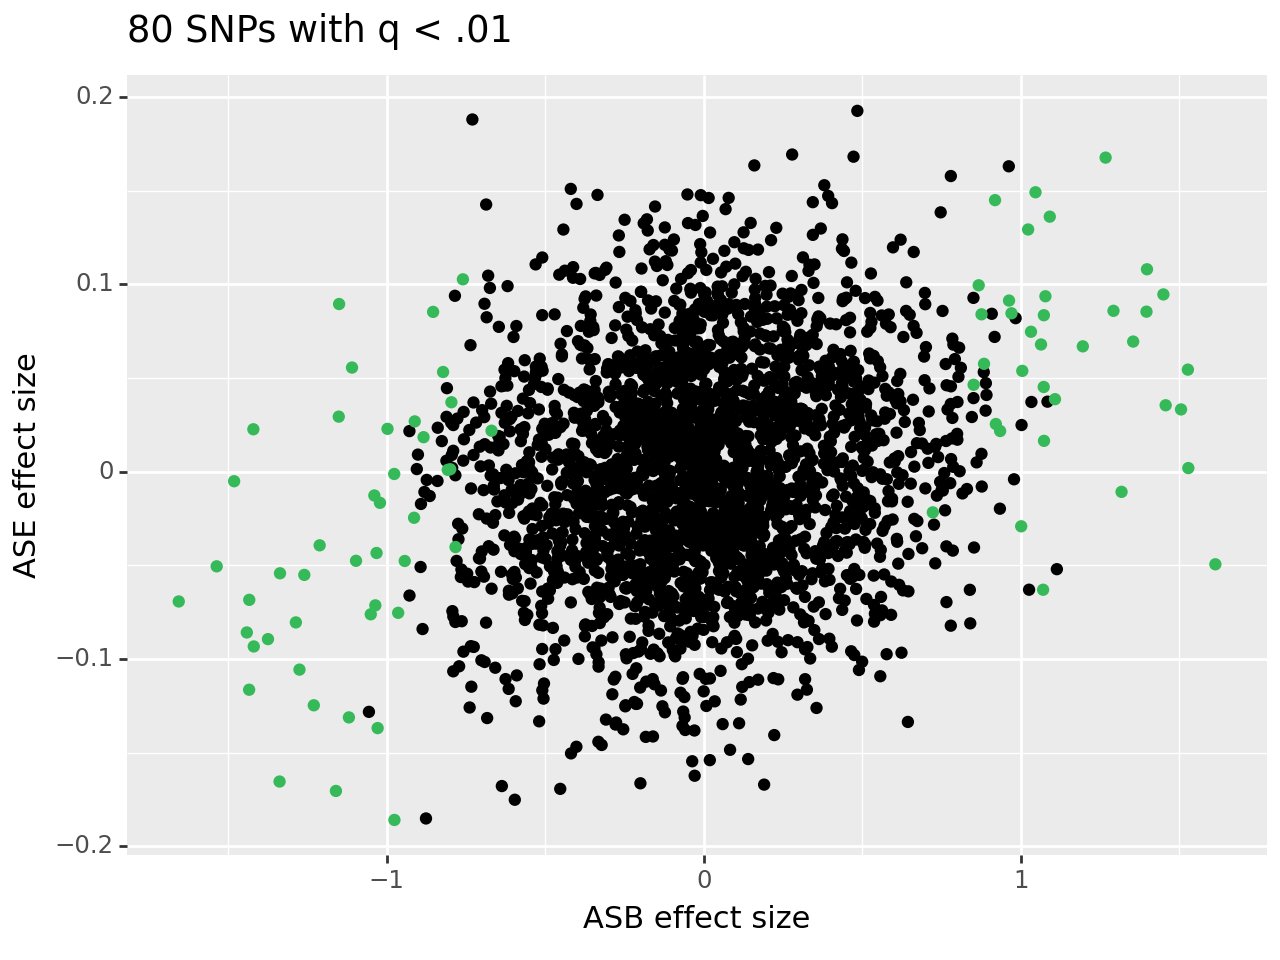

<Figure Size: (640 x 480)>

In [84]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

For intersecting Peaks and SNPs you can use `bedtools -U` or use the interval tree that David sent

Want to filter out based on peaks so you don't get the bias

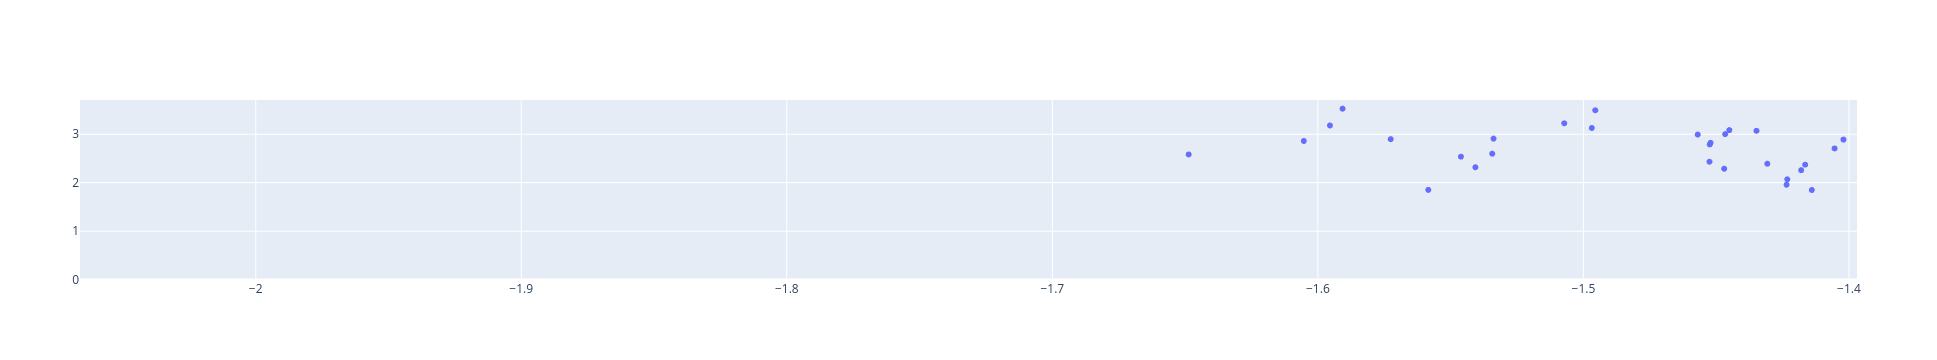

In [132]:
import plotnine as p9
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

ggplot_data = results

plotly_trace = go.Scatter(x=ggplot_data['asb_loc'], y=-np.log10(ggplot_data['asb_q']), text = ggplot_data["variantID"], mode='markers', )
fig = make_subplots()
fig.add_trace(plotly_trace)
fig.show()

In [168]:
results[(results.asb_q < .01) & (np.abs(results.asb_loc) > 1) & 
        (results.refCount_input > 4) &
        (results.altCount_input > 4) &
        (results.refCount_IP    > 4) &
        (results.altCount_IP    > 4)
       ][["variantID", "refAllele", "altAllele", "refCount_input", "altCount_input", "refCount_IP", "altCount_IP", "ase_loc", "ase_q", "asb_loc", "asb_q"]]

variantID refAllele altAllele  refCount_input  altCount_input  \
966    rs4594115         A         T              15               6   
1317   rs4774360         C         T               6               7   
2418  rs60795647         C         G               6               8   
2844  rs16856484         G         A              41              64   
3024   rs1040554         C         T              46              23   
4694      rs4013         C         T              36              46   
4703    rs223410         T         C              45              28   
5050    rs258017         C         T              24              35   
5519      rs4816         G         A              35              55   
5743  rs34661737         T         A              10               9   
5886  rs17149107         G         T              57              51   
6600   rs1468931         G         A              14              20   

      refCount_IP  altCount_IP   ase_loc     ase_q   asb_loc     asb_q  
966             8           66 -0.076130  0.377125  1.030768  0.006443  
1317           92            9 -0.206024  0.240971 -1.005312  0.006573  
2418            6           51  0.206043  0.225607  1.083594  0.005776  
2844            5           52  0.323517  0.034418  1.111505  0.004159  
3024            5           38 -0.204541  0.165072  1.031175  0.002128  
4694            6           48  0.148214  0.265656  1.052217  0.008178  
4703            5           49 -0.029771  0.438758  1.115435  0.003698  
5050          159           20  0.081145  0.350657 -1.231360  0.000589  
5519           32            6  0.179938  0.174485 -1.001002  0.003778  
5743           56            6 -0.162013  0.272025 -1.125952  0.001545  
5886           10           74  0.054327  0.388493  1.081333  0.000681  
6600           39            7  0.045080  0.430588 -1.042767  0.009692

In [ ]:
results.in_peak

In [132]:
results[(results.asb_q < .01) & (np.abs(results.asb_loc) > 1) & 
        (results.in_peak == 1)
       ][["contig", "position", "variantID", "refAllele", "altAllele", "refCount_input", "altCount_input", "refCount_IP", "altCount_IP", "ase_loc", "ase_q", "asb_loc", "asb_q"]].rename(columns={"ase_loc": "ASE effect size", 
       "ase_q": "ASE q-value", "asb_loc": "ASB effect size", "asb_q": "ASB q-value"})

contig   position   variantID refAllele altAllele  refCount_input  \
618   chr12   46436069   rs4768121         A         G               8   
966   chr13   93233936   rs4594115         A         T              15   
1234  chr15   24974048   rs2554426         G         T             349   
1317  chr15   60434381   rs4774360         C         T               6   
2418   chr1   64082865  rs60795647         C         G               6   
2419   chr1   64082986   rs6668064         G         T               7   
2669   chr1  204100710   rs3795579         G         T              13   
4604   chr4   87926944  rs72657975         G         T             571   
4606   chr4   87927473  rs10002782         A         G             173   
4608   chr4   87931491  rs10005067         T         C             506   
4782   chr4  130045708   rs1022005         A         C               4   
5050   chr5  116473354    rs258017         C         T              24   

      altCount_input  refCount_IP  altCount_IP  ASE effect size   ASE q-value  \
618                7           36            0        -0.381037  6.161804e-02   
966                6            8           66        -0.076130  3.771250e-01   
1234               5          298            2        -1.906768  9.401624e-15   
1317               7           92            9        -0.206024  2.409710e-01   
2418               8            6           51         0.206043  2.256074e-01   
2419              11            4           44         0.293901  1.178405e-01   
2669              14           31            0        -0.250733  1.436236e-01   
4604               6          375            4        -2.089426  6.178014e-26   
4606              10          388            4        -1.410613  1.215197e-09   
4608               6          238            0        -2.076872  1.991957e-18   
4782               6           30            1        -0.178796  2.442273e-01   
5050              35          159           20         0.081145  3.506575e-01   

      ASB effect size  ASB q-value  
618         -1.405412     0.001967  
966          1.030768     0.006443  
1234        -1.446992     0.005151  
1317        -1.005312     0.006573  
2418         1.083594     0.005776  
2419         1.065249     0.007650  
2669        -1.242971     0.006672  
4604        -1.374112     0.004673  
4606        -1.546124     0.002907  
4608        -2.106251     0.008537  
4782        -1.191470     0.003657  
5050        -1.231360     0.000589

rs10005067 is a risk allele for "Total body bone mineral density (age 30-45)" falls in a large intergenic region
rs28028 is in an intronic region of SEMA6A gene; no clear GWAS signal or clinical significance
rs6684 in exonic region of NDUFAF4 gene; no clear GWAS signal or clinical significance
rs17126159 ROR1 : Intron Variant with no reported clinical significance

In [112]:
fdr_threshold

0.05

In [1]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold=0.05, sig_alpha=0.1)

NameError: name 'reload' is not defined

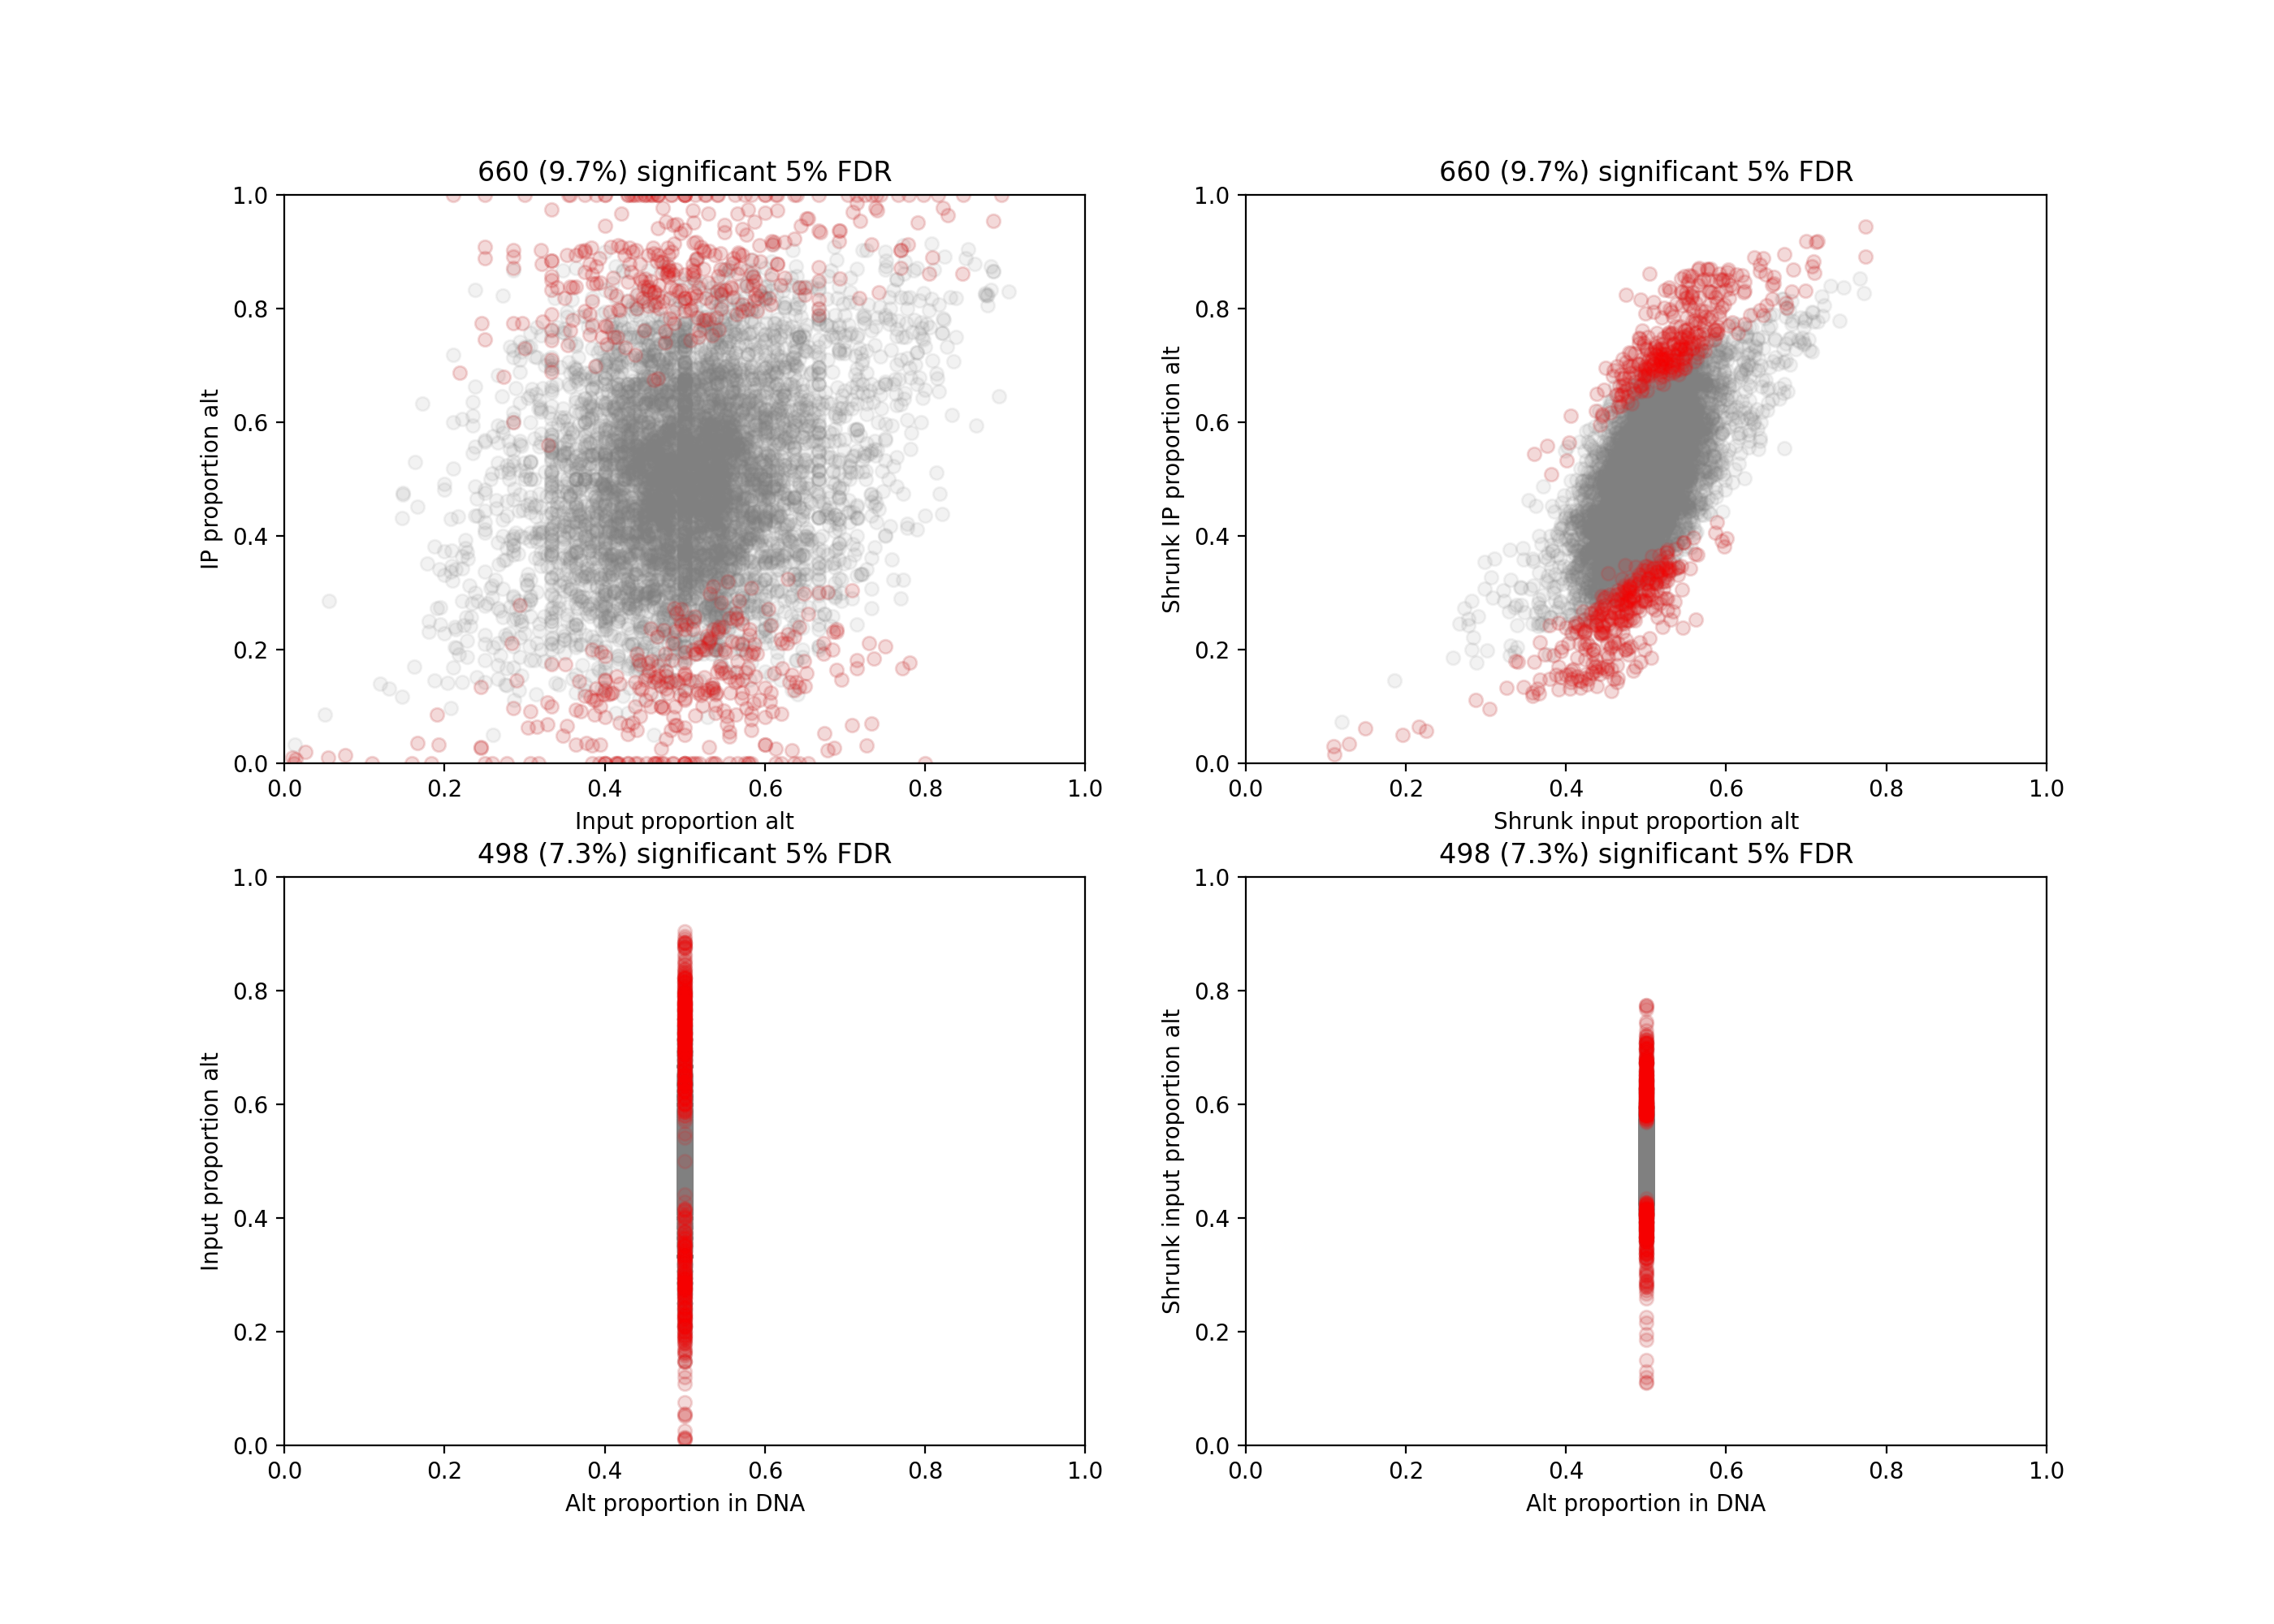

()

In [114]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold=0.05, sig_alpha=0.1)

For the beta model we model the two ratios (input and IP) separately but allow posterior dependence through the structured guide. For the Gaussian model we model the ASE effect (difference between DNA and RNA logit ratio) and ASB effect (difference between RNA and IP logit ratio). 

# Gaussian model without replicates

Could also run this with the mean field guide. 

In [107]:
%matplotlib inline
results = gaussian_model.fit_and_save(dat_subsub, 
                                         results_dir / ("normal" 
                                                        + ("_struct" if use_structured_guide else "") 
                                                        + ".tsv.gz"),
                                         use_structured_guide = True,
                                         iterations = 1000,
                                         device = "cuda:0")

Learned hyperparameters: {'ase_scale': 0.21795596182346344, 'input_count_conc': 245.8440399169922, 'asb_scale': 0.5056506395339966, 'IP_count_conc': 20.21240234375, 'ase_t_df': 3.47109055519104, 'asb_t_df': 5.234928131103516}


AttributeError: 'tuple' object has no attribute 'input_ratio'

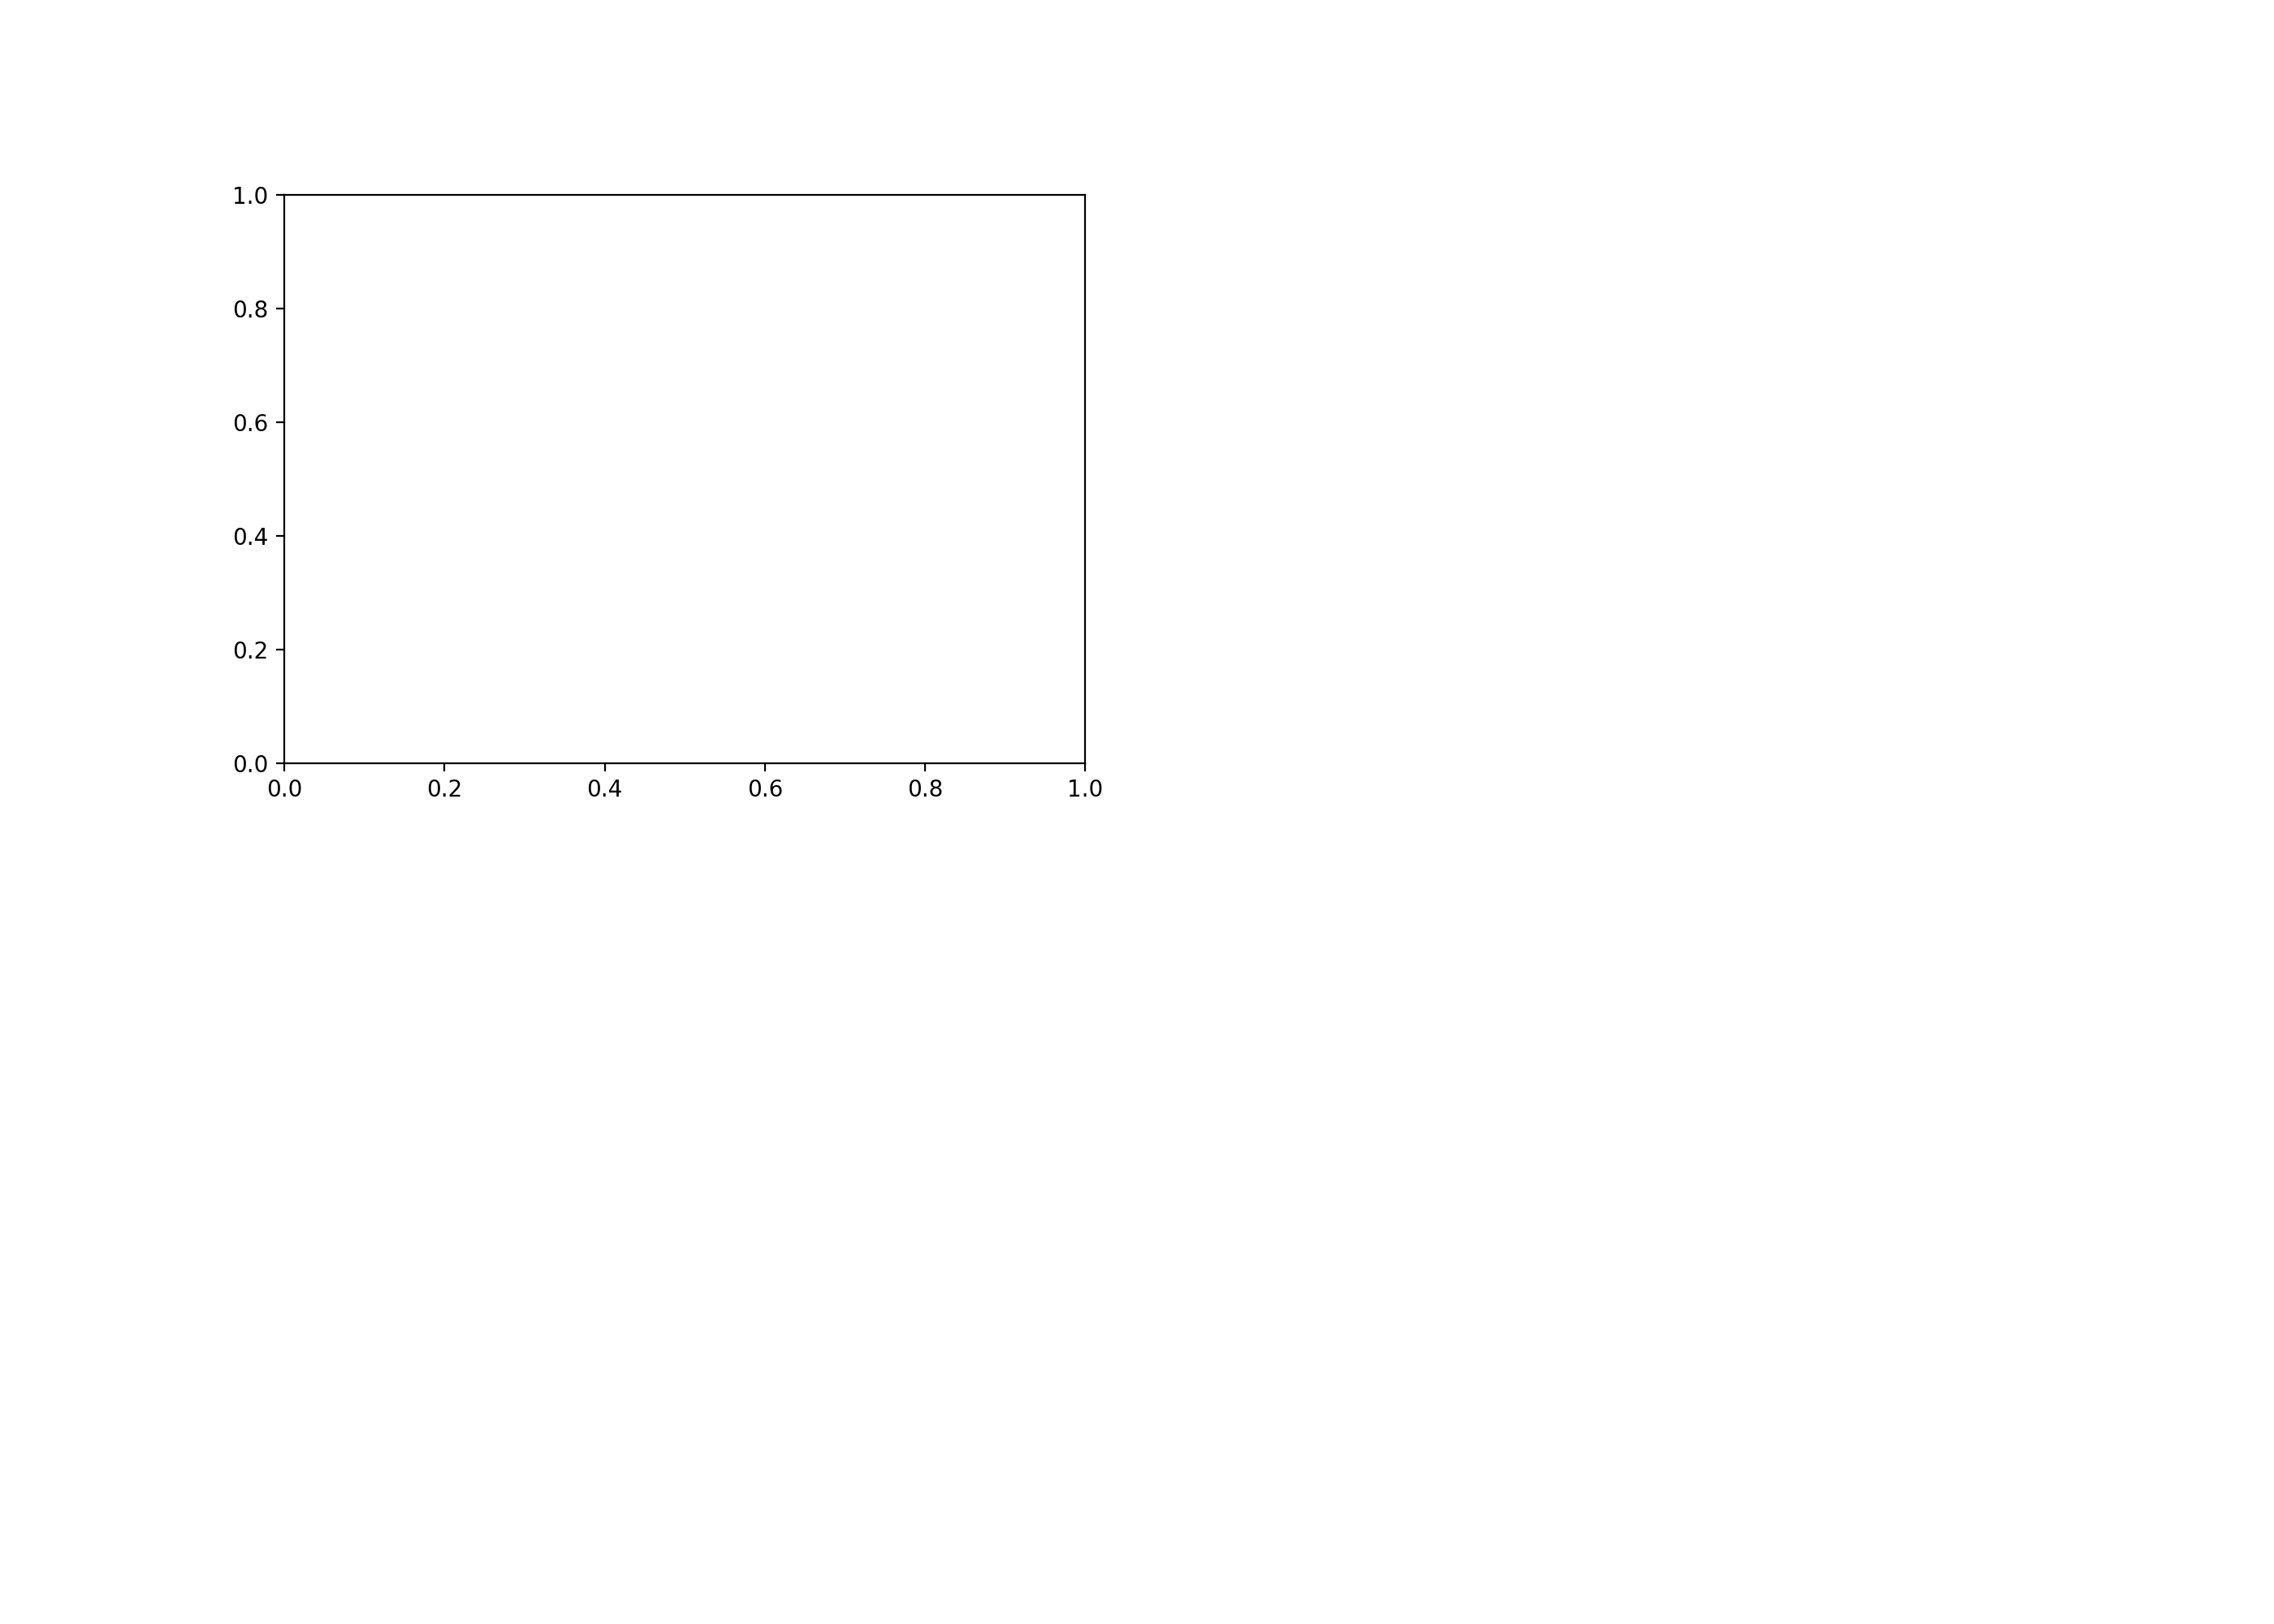

In [108]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold, sig_alpha=0.4)

In [175]:
!ls /home/dmeyer/projects/bqtls

allhet_fixedH.1kg.vcf.gz	     old_secondround_bqtls
allhet_fixedH.1kg.vcf.gz.tbi	     sanger.feather
CW70142.phased.csv		     sanger.vcf.gz
hg38				     SecondRound_bQTLs
ipsc_imputation_het_hg38.feather     tdp43
ipsc_imputation_het_hg38.vcf.gz      tdp43-all_peaks.narrowPeak
ipsc_imputation_het_hg38.vcf.gz.tbi


## Overlap peak information:

.narrowPeak format: 
```
chrom - Name of the chromosome (or contig, scaffold, etc.).
chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.
name - Name given to a region (preferably unique). Use "." if no name is assigned.
score - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.
strand - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.
signalValue - Measurement of overall (usually, average) enrichment for the region.
pValue - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.
qValue - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.
peak - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.
```

In [10]:
!ls /gpfs/commons/home/dmeyer/bindingQTL_share/rb-209/peaks

### peaks_file = Path("/home/dmeyer/projects/bqtls/tdp43-all_peaks.narrowPeak")

In [6]:
peaks = pd.read_csv(peaks_file, 
                    header = None,
                    names= ["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"],
                    sep = "\t",  
                    index_col = False)
peaks.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/dmeyer/projects/bqtls/tdp43-all_peaks.narrowPeak'

In [79]:
peak_tree = interval_utils.to_interval_trees(peaks, peaks.chrom.unique())

In [80]:
from pooledQTL import interval_utils

exons = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/gencode.v38.exons.txt.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons

In [81]:
exons_tree = interval_utils.to_interval_trees(exons, exons.chrom.unique())

In [82]:
genc = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/gencode.v38.annotation.gtf.gz", 
                       sep = "\t",  index_col = False, header=None, comment="#", usecols = range(5))
genc = genc.rename(columns={k:x for (k,x) in enumerate(["chrom", "gene", "annotation", "start", "end"])})

genc = genc[(genc.end - genc.start) >= 9] # remove super short annotations

In [83]:
genc.head()

chrom    gene  annotation  start    end
0  chr1  HAVANA        gene  11869  14409
1  chr1  HAVANA  transcript  11869  14409
2  chr1  HAVANA        exon  11869  12227
3  chr1  HAVANA        exon  12613  12721
4  chr1  HAVANA        exon  13221  14409

In [228]:
genc.annotation.unique()

array(['gene', 'transcript', 'exon', 'CDS', 'UTR'], dtype=object)

In [84]:
def f(x):
    return interval_utils.to_interval_trees(x, genc.chrom.unique())
gene_tree = f(genc[genc.annotation == "gene"][genc.columns[[0,3,4]]])
transcript_tree = f(genc[genc.annotation == "transcript"][genc.columns[[0,3,4]]])
utr_tree = f(genc[genc.annotation == "UTR"][genc.columns[[0,3,4]]])

In [85]:
results["in_peak"] = interval_utils.get_overlap(peak_tree, results.rename(columns={"contig": "chrom"}))
results["in_exon"] = interval_utils.get_overlap(exons_tree, results.rename(columns={"contig": "chrom"}))
results["in_transcript"] = interval_utils.get_overlap(transcript_tree, results.rename(columns={"contig": "chrom"}))
results["in_gene"] = interval_utils.get_overlap(gene_tree, results.rename(columns={"contig": "chrom"}))
results["in_utr"] = interval_utils.get_overlap(utr_tree, results.rename(columns={"contig": "chrom"}))

In [86]:
results_file

PosixPath('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.4_ipreads30_struct.tsv.gz')

In [87]:
results.rename(columns={"contig": "chrom"}).to_csv(Path('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.4_ipreads30_struct_with_peaks.tsv.gz'), sep="\t", index=False)

In [118]:
results.rename(columns={"contig": "chrom"}).to_csv(Path('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.3_totalreads30_struct_with_peaks.tsv.gz'), sep="\t", index=False)

In [ ]:

results.rename(columns={"contig": "chrom"}).to_csv(Path('/home/dmeyer/projects/bqtls/tdp43/beta_filtered_epsilon0.2_totalreads10_struct_with_peaks.tsv.gz'), sep="\t", index=False)

In [102]:
thresh = 0.05
f'{sum((results["asb_q"] < thresh) & (results["in_peak"] == 1))/sum(results["asb_q"] < thresh)*100:.3}% of hits in peaks'

'12.6% of hits in peaks'

In [83]:
f'{sum((results["asb_q"] < 0.05) & (results["in_peak"] == 1)),sum(results["asb_q"] < 0.05)}'

'(83, 660)'

In [87]:
sum((results["in_peak"] == 1))/6789

0.21034025629695094

In [86]:
results.shape

(6789, 23)

In [72]:
results[(results["asb_q"] < 0.05) & (results["in_peak"] == 1)]

contig  position_hg19    variantID refAllele altAllele   position  \
16    chr10        3162904  rs114964193         T         G    3120712   
237   chr10      125157127  rs117421392         C         T  123397611   
272   chr10      134998066    rs4838671         C         T  133184562   
360   chr11       47437403    rs2293578         C         T   47415852   
485   chr11      117133672     rs552176         A         G  117262956   
...     ...            ...          ...       ...       ...        ...   
6411   chr8      101726965    rs1786319         T         C  100714737   
6612   chr9       90128429    rs1316489         A         G   87513514   
6670   chr9      101874314   rs10819638         C         T   99112032   
6676   chr9      102896238    rs2761056         A         G  100133956   
6766   chr9      134306768    rs9802853         C         T  131431381   

      refCount_input  altCount_input  totalCount_input  pred_ratio  ...  \
16                10              12                22         0.5  ...   
237                4              10                14         0.5  ...   
272                7               5                12         0.5  ...   
360               19              18                37         0.5  ...   
485                4               6                10         0.5  ...   
...              ...             ...               ...         ...  ...   
6411               8               6                14         0.5  ...   
6612              19              16                35         0.5  ...   
6670              14               7                21         0.5  ...   
6676              11               7                18         0.5  ...   
6766               7              13                20         0.5  ...   

      totalCount_IP  shrunk_input_logratio   ase_loc    ase_sd     ase_q  \
16               46               0.130916  0.130916  0.242681  0.294785   
237              33               0.070365  0.070365  0.258286  0.392646   
272             208              -0.002768 -0.002768  0.239321  0.495386   
360             202              -0.189779 -0.189779  0.200045  0.171391   
485              37              -0.216147 -0.216147  0.249425  0.193086   
...             ...                    ...       ...       ...       ...   
6411             36              -0.407350 -0.407350  0.244236  0.047672   
6612             50              -0.295695 -0.295695  0.242712  0.111556   
6670            138              -0.176318 -0.176318  0.214342  0.205367   
6676             64               0.076987  0.076987  0.234403  0.371290   
6766             57               0.237772  0.237772  0.224343  0.144604   

      shrunk_IP_logratio   asb_loc    asb_sd     asb_q  in_peak  
16              0.837034  0.706118  0.407591  0.041600        1  
237            -0.694818 -0.765182  0.396229  0.026732        1  
272             0.827187  0.829956  0.413721  0.022424        1  
360            -0.690932 -0.501154  0.301710  0.048352        1  
485            -1.206328 -0.990181  0.516098  0.027518        1  
...                  ...       ...       ...       ...      ...  
6411           -1.693513 -1.286163  0.579520  0.013231        1  
6612           -1.309898 -1.014204  0.449180  0.011976        1  
6670            0.475239  0.651558  0.344581  0.029321        1  
6676            0.944620  0.867633  0.482507  0.036074        1  
6766            1.049295  0.811522  0.405979  0.022808        1  

[83 rows x 22 columns]

In [ ]:
results[(results["asb_q"] < 0.05) & (results["in_peak"] == 1)]

In [70]:
results["in_peak"].unique()

array([0, 1])

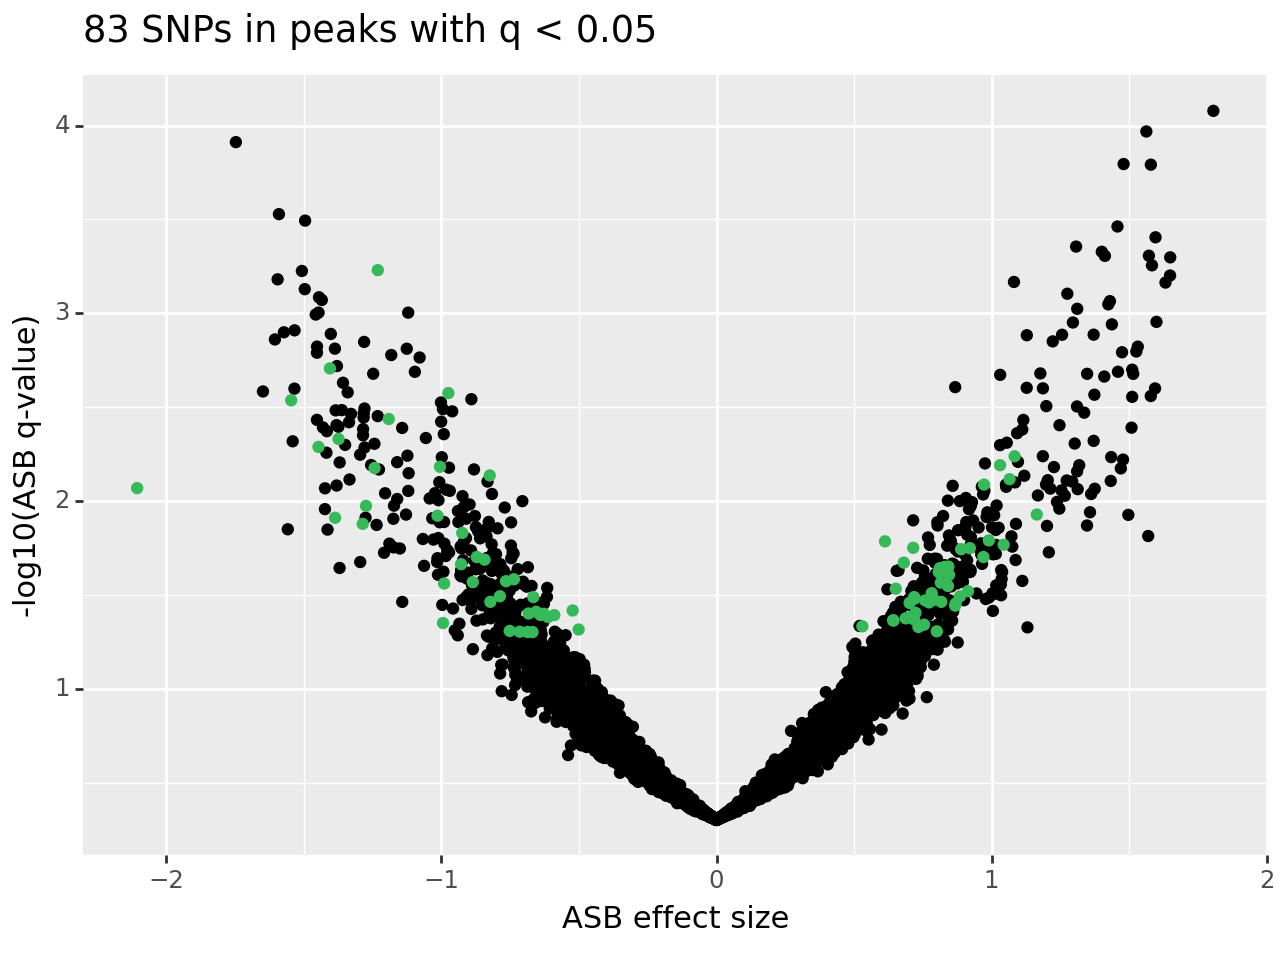

<Figure Size: (640 x 480)>

In [112]:
thresh=0.05
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "-np.log10(asb_q)")) +
 p9.geom_point(data=results[(results.asb_q >= thresh)|(results.in_peak!=1)])+
 p9.geom_point(data=results[(results.asb_q < thresh)&(results.in_peak==1)], color='#36ba59')+
    p9.labs(x = "ASB effect size", y = "-log10(ASB q-value)", title = f"{sum((results.asb_q < thresh)&(results.in_peak==1))} SNPs in peaks with q < {thresh}")
)
p

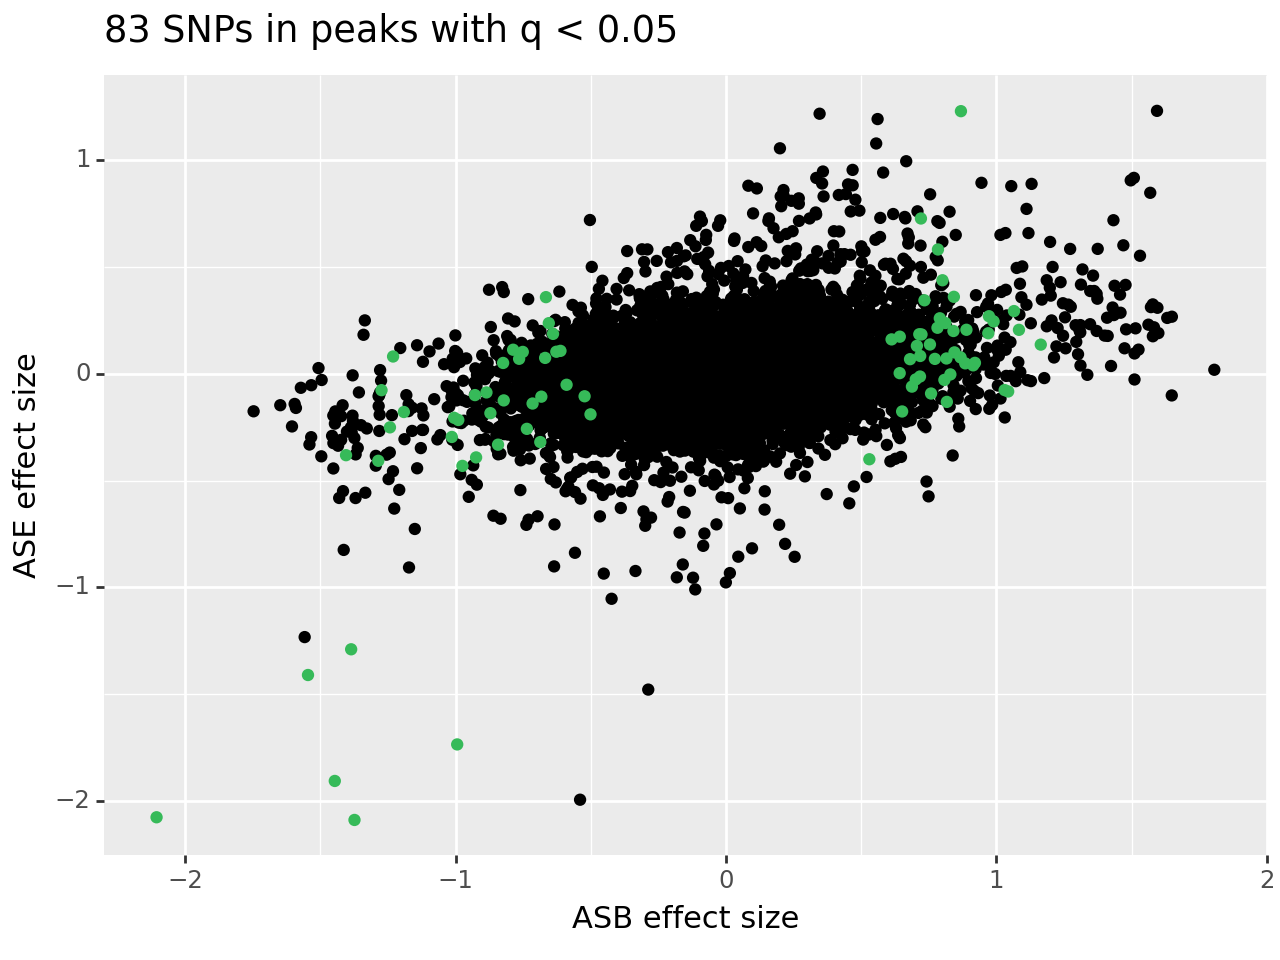

<Figure Size: (640 x 480)>

In [113]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[(results.asb_q >= thresh)|(results.in_peak!=1)])+
 p9.geom_point(data=results[(results.asb_q < thresh)&(results.in_peak==1)], color='#36ba59')+
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum((results.asb_q < thresh)&(results.in_peak == 1))} SNPs in peaks with q < {thresh}")
)
p

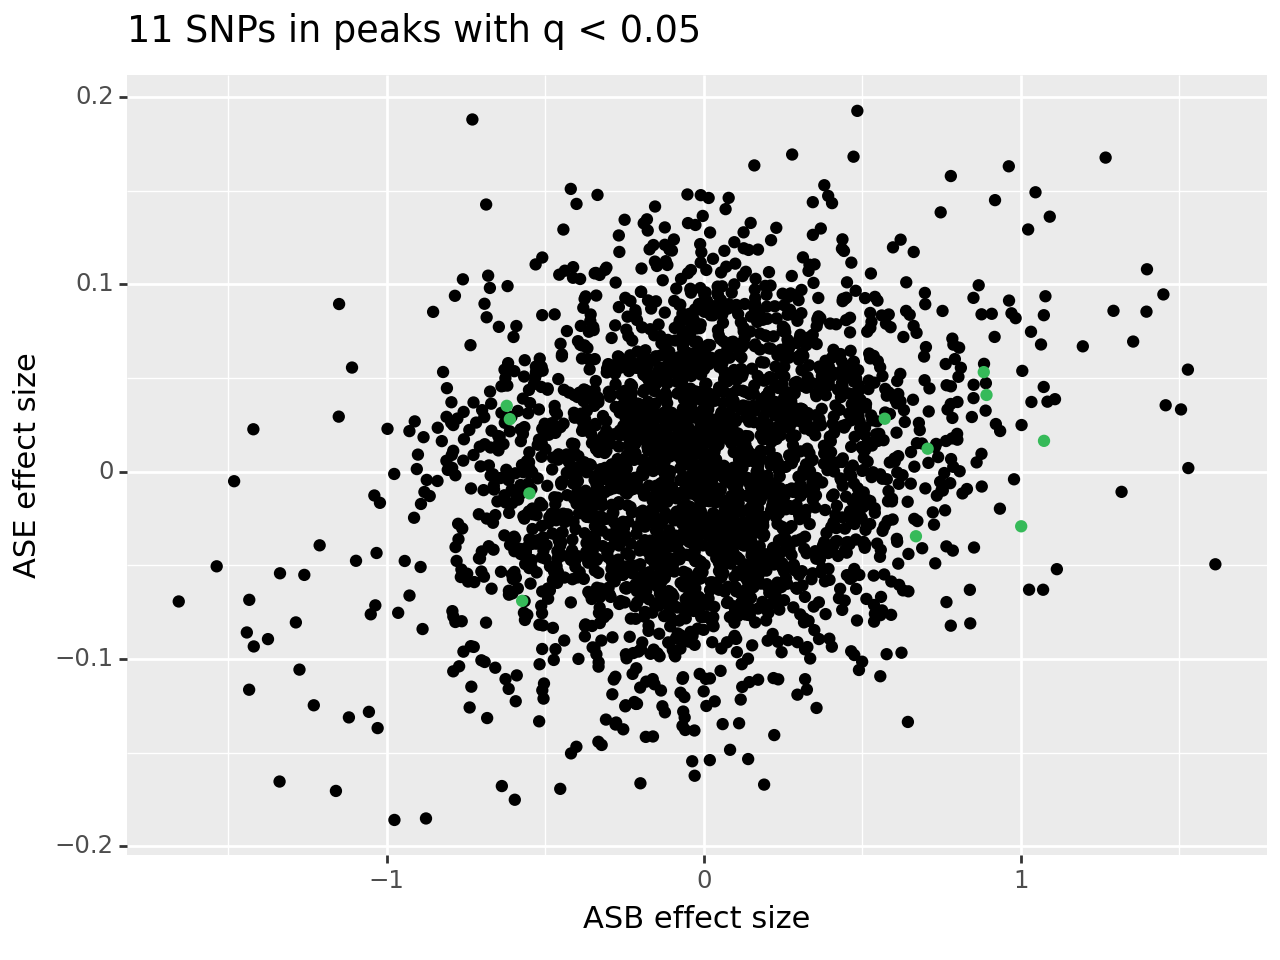

<Figure Size: (640 x 480)>

In [100]:
thresh=0.05
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[(results.asb_q >= thresh)|(results.in_peak!=1)])+
 p9.geom_point(data=results[(results.asb_q < thresh)&(results.in_peak==1)], color='#36ba59')+
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum((results.asb_q < thresh)&(results.in_peak == 1))} SNPs in peaks with q < {thresh}")
)
p

In [102]:
print("\n".join(results.variantID[(results.asb_q < thresh)&(results.in_peak==1)]))

rs17801478
rs3203780
rs57094846
rs28773296
rs4539869
rs12715572
rs9862251
rs79563282
rs10473842
rs1052623
rs700082


In [134]:
results

contig  position_hg19   variantID refAllele altAllele   position  \
0     chr10        1040138   rs7070724         G         A     994198   
1     chr10        1046712   rs2306409         G         A    1000772   
2     chr10        1065191  rs17221491         A         G    1019251   
3     chr10        1675548  rs12267329         A         G    1633353   
4     chr10        1682481  rs10903520         G         A    1640286   
...     ...            ...         ...       ...       ...        ...   
6784   chr9      139318071      rs7628         A         G  136423619   
6785   chr9      139335599   rs1127152         A         G  136441147   
6786   chr9      139371786   rs6560632         A         C  136477334   
6787   chr9      139618283      rs6873         A         G  136723831   
6788   chr9      139619366      rs6866         C         G  136724914   

      refCount_input  altCount_input  totalCount_input  pred_ratio  ...  \
0                  8               8                16         0.5  ...   
1                 51              74               125         0.5  ...   
2                  4              10                14         0.5  ...   
3                  5               6                11         0.5  ...   
4                  6              10                16         0.5  ...   
...              ...             ...               ...         ...  ...   
6784              55              50               105         0.5  ...   
6785              37              19                56         0.5  ...   
6786              43              24                67         0.5  ...   
6787              34              31                65         0.5  ...   
6788              33              32                65         0.5  ...   

      shrunk_input_logratio   ase_loc    ase_sd     ase_q  shrunk_IP_logratio  \
0                  0.009045  0.009045  0.242887  0.485147           -0.181023   
1                  0.136659  0.136659  0.200529  0.247780           -0.435006   
2                  0.145541  0.145541  0.320083  0.324664            0.228376   
3                  0.171201  0.171201  0.249057  0.245916            0.689264   
4                 -0.036610 -0.036610  0.232647  0.437479           -0.279682   
...                     ...       ...       ...       ...                 ...   
6784              -0.180091 -0.180091  0.226761  0.213543           -0.209754   
6785              -0.331026 -0.331026  0.213242  0.060290           -0.584175   
6786              -0.328250 -0.328250  0.206881  0.056295           -0.575466   
6787              -0.084877 -0.084877  0.211950  0.344411           -0.901133   
6788              -0.159886 -0.159886  0.195265  0.206447           -0.540989   

       asb_loc    asb_sd     asb_q  in_peak  in_exon  
0    -0.190068  0.457175  0.338798        0        0  
1    -0.571664  0.424223  0.088901        0        1  
2     0.082835  0.447758  0.426614        0        1  
3     0.518062  0.441253  0.120183        1        0  
4    -0.243072  0.439876  0.290272        1        0  
...        ...       ...       ...      ...      ...  
6784 -0.029663  0.444518  0.473398        0        1  
6785 -0.253149  0.471046  0.295489        0        1  
6786 -0.247216  0.392782  0.264545        0        1  
6787 -0.816257  0.346087  0.009174        0        1  
6788 -0.381103  0.447421  0.197169        0        1  

[6789 rows x 23 columns]

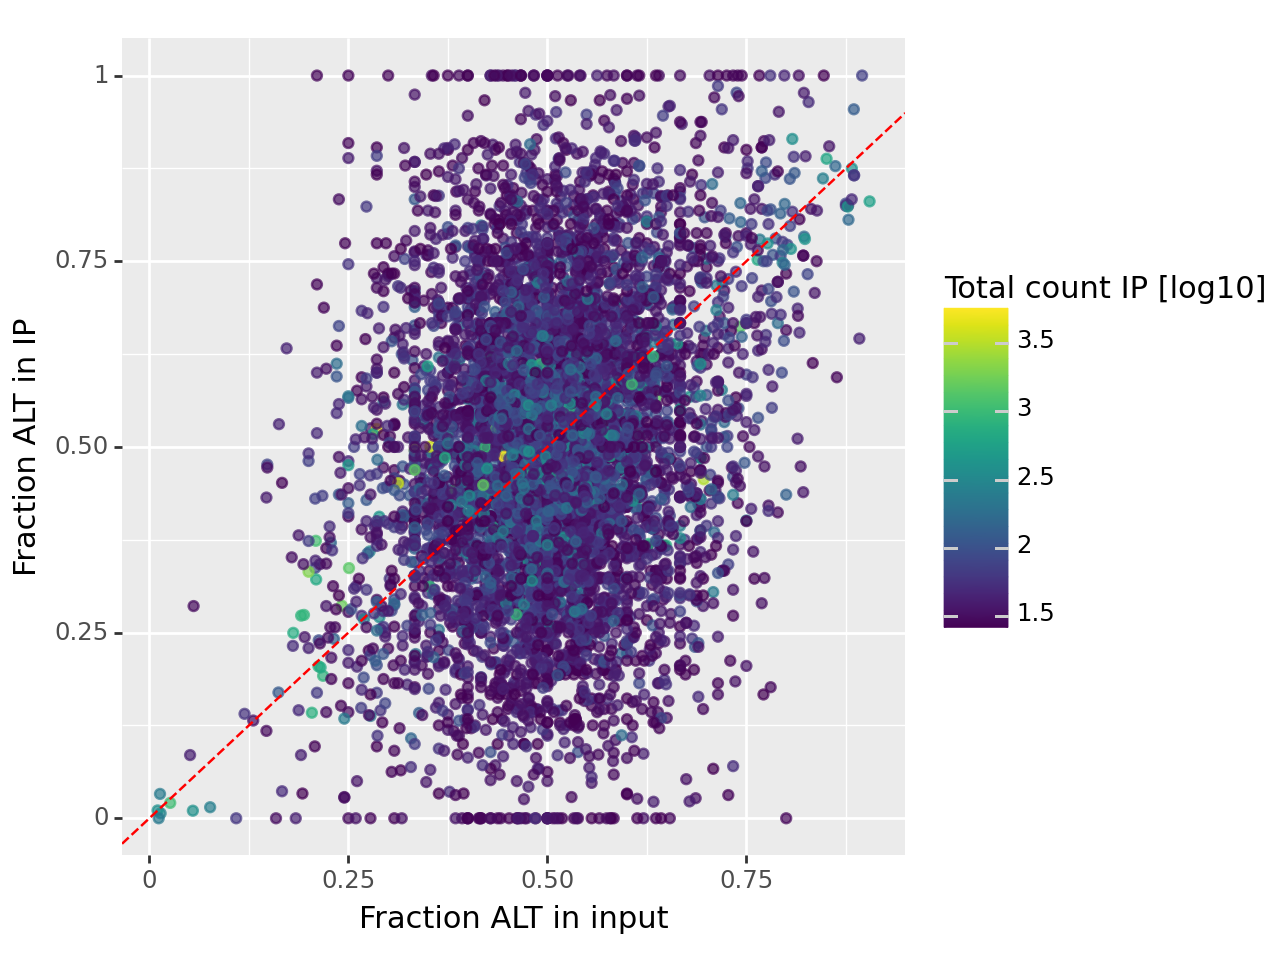

<Figure Size: (640 x 480)>

In [154]:
p = (p9.ggplot(results, p9.aes(x = "altCount_input/totalCount_input", y = "altCount_IP/totalCount_IP", color="np.log10(totalCount_IP)")) +
 p9.geom_point(data=results, alpha=0.7)+
# p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
     p9.geom_abline(slope = 1, intercept = 0, color="red", linetype="dashed")+
     p9.labs(x = "Fraction ALT in input", y="Fraction ALT in IP", color="Total count IP [log10]")
 #p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

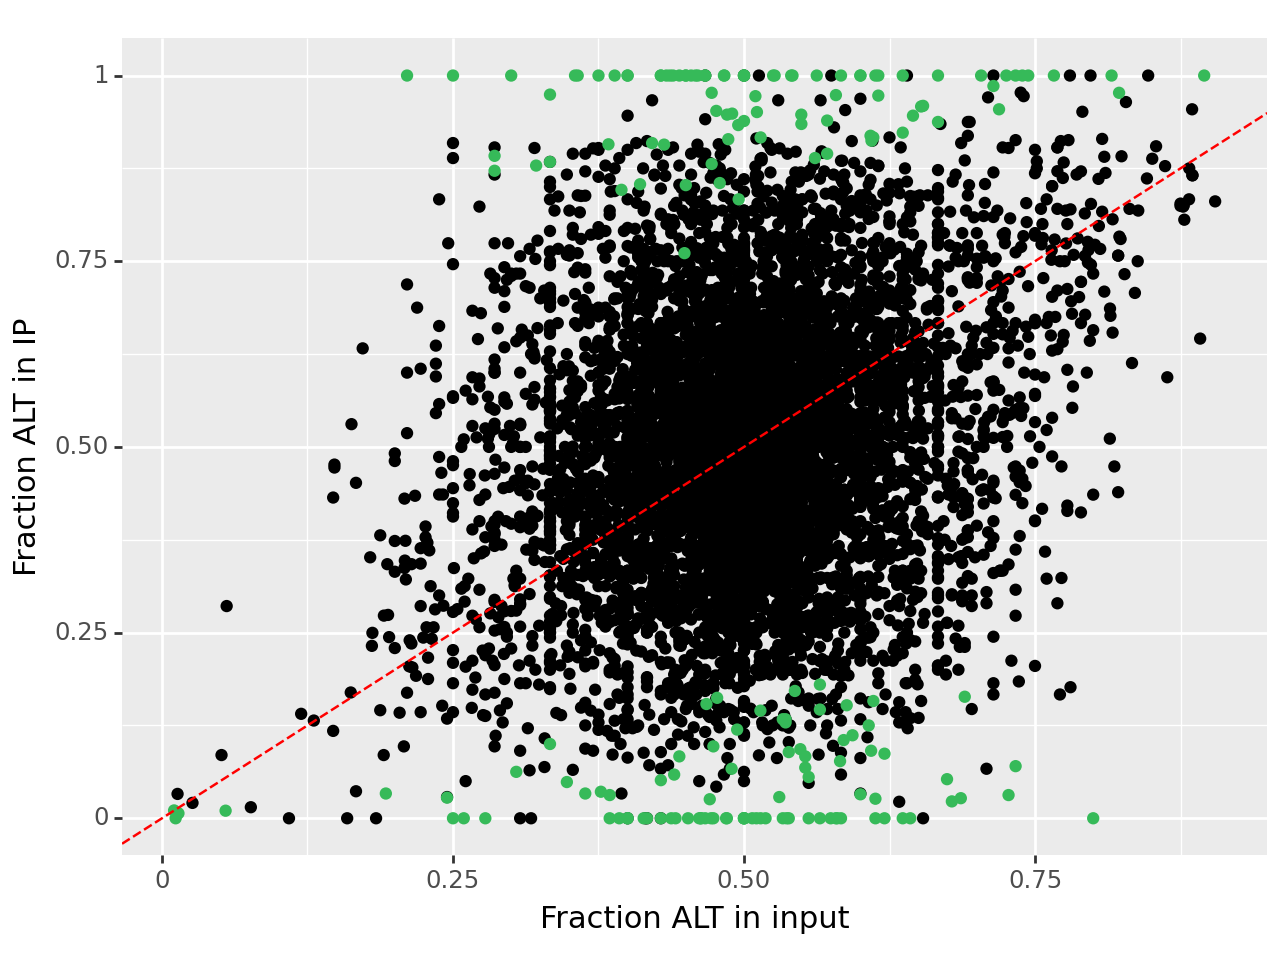

<Figure Size: (640 x 480)>

In [151]:
p = (p9.ggplot(results, p9.aes(x = "altCount_input/totalCount_input", y = "altCount_IP/totalCount_IP")) +
     p9.geom_point(data=results[results.asb_q >= 0.01])+
     p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
     p9.geom_abline(slope = 1, intercept = 0, color="red", linetype="dashed")+
     p9.labs(x = "Fraction ALT in input", y="Fraction ALT in IP")
 #p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

In [161]:
phased[phased.SNP == "rs12608932"]#[sample_ind]

contig  position         SNP refAllele altAllele   GT  dosage1  \
1050807  chr19  17752689  rs12608932         A         C  1|0     0.65   

         dosage2  
1050807     0.25

In [164]:
results[results.variantID == "rs12973192"]

Empty DataFrame
Columns: [contig, position_hg19, variantID, refAllele, altAllele, position, refCount_input, altCount_input, totalCount_input, pred_ratio, refCount_IP, altCount_IP, totalCount_IP, shrunk_input_logratio, ase_loc, ase_sd, ase_q, shrunk_IP_logratio, asb_loc, asb_sd, asb_q, in_peak, in_exon]
Index: []

[0 rows x 23 columns]

In [169]:
dat[dat.variantID == "rs12608932"]

Empty DataFrame
Columns: [contig, position, variantID, refAllele, altAllele, refCount, altCount, totalCount]
Index: []

In [170]:
dat[dat.variantID == "rs12973192"]

Empty DataFrame
Columns: [contig, position, variantID, refAllele, altAllele, refCount, altCount, totalCount]
Index: []

In [171]:
dat_IP[dat_IP.variantID == "rs12608932"]

contig  position   variantID refAllele altAllele  refCount  altCount  \
1481561  chr19  17641880  rs12608932         A         C       816         2   

         totalCount  
1481561         818

In [172]:
dat_IP[dat_IP.variantID == "rs12973192"]

contig  position   variantID refAllele altAllele  refCount  altCount  \
1481566  chr19  17642430  rs12973192         C         G       651         0   

         totalCount  
1481566         651

## 2024-01-26 request from David

How about we look at input SNPs and try to filter

```
mostly for Dan: Megan and i met yesterday. one idea we discussed is trying to filter for SNPs that we are confident show balance in the input, rather than trying to account for ASE in the ASB model. the question is how many SNPs we’d even get to test, especially in intronic regions where the input counts are low.
so, i think a good thing for you to try would be get a binomial confidence interval for the allelic proportion for each input SNP
i think you can do this with binomial.test
(actually i think the simulation code probably does that?)
we’d want that CI to be contained in [p-epsilon, p+epsilon] where p is the expected proportion (i.e. 0.5 in the single individual setting, whatever comes out of the deconvolution regression for the pooled setting)
you could vary epsilon in some range (maybe something like 0.1 would be a good starting point?) and see how many intronic and exonic SNP we would be able to test
probably easiest with a single individual first: i’m not sure quite how we should handle the situation where p is close to 0 or 1
```

In [241]:
x =  input_counts[0]

x["in_peak"] = interval_utils.get_overlap(peak_tree, x.rename(columns={"contig": "chrom"}))
x["in_exon"] = interval_utils.get_overlap(exons_tree, x.rename(columns={"contig": "chrom"}))
x["in_transcript"] = interval_utils.get_overlap(transcript_tree, x.rename(columns={"contig": "chrom"}))
x["in_gene"] = interval_utils.get_overlap(gene_tree, x.rename(columns={"contig": "chrom"}))
x["in_utr"] = interval_utils.get_overlap(utr_tree, x.rename(columns={"contig": "chrom"}))
x.to_csv("/home/dmeyer/projects/bqtls/tdp43/allelic/tdp43_input_annotated_allelic.out", index_label=False, sep="\t", index=False)

In [242]:
x = IP_counts[0]
x["in_peak"] = interval_utils.get_overlap(peak_tree, x.rename(columns={"contig": "chrom"}))
x["in_exon"] = interval_utils.get_overlap(exons_tree, x.rename(columns={"contig": "chrom"}))
x["in_transcript"] = interval_utils.get_overlap(transcript_tree, x.rename(columns={"contig": "chrom"}))
x["in_gene"] = interval_utils.get_overlap(gene_tree, x.rename(columns={"contig": "chrom"}))
x["in_utr"] = interval_utils.get_overlap(utr_tree, x.rename(columns={"contig": "chrom"}))
x.to_csv("/home/dmeyer/projects/bqtls/tdp43/allelic/tdp43_ip_annotated_allelic.out", index_label=False, sep="\t", index=False)

In [243]:
x

contig   position    variantID refAllele altAllele  refCount  \
0         chr1     128747  rs565117739         A         C        11   
1         chr1     137978  rs529853750         G         A       124   
2         chr1     139029  rs531551691         C         T        45   
3         chr1     139030  rs751110858         G         A        45   
4         chr1     139060  rs568513188         G         A        37   
...        ...        ...          ...       ...       ...       ...   
1620755  chr22   50785210  rs138253809         C         T        22   
1620756  chr22   50788205            .         A         T        11   
1620757  chr22   50798982            .         G         A        26   
1620758  chr22   50799058            .         G         C        31   
1620759   chrX  154768713  rs192006955         C         T        12   

         altCount  totalCount  in_peak  in_exon  in_transcript  in_gene  \
0               1          12        0        0              1        1   
1               0         124        0        0              0        0   
2               0          45        0        0              0        0   
3               0          45        0        0              0        0   
4               0          37        0        0              0        0   
...           ...         ...      ...      ...            ...      ...   
1620755         0          22        0        1              1        1   
1620756         0          11        0        0              1        1   
1620757         0          26        0        1              1        1   
1620758         0          31        0        1              1        1   
1620759         0          12        0        1              1        1   

         in_utr  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1620755       0  
1620756       0  
1620757       0  
1620758       0  
1620759       0  

[1620760 rows x 13 columns]